# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The goals of this project are the following:

<ul>
<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
<li>Apply a distortion correction to raw images.
<li>Use color transforms, gradients, etc., to create a thresholded binary image.
<li>Apply a perspective transform to rectify binary image (birds-eye view).
<li>Detect lane pixels and fit to find the lane boundary.
<li>Determine the curvature of the lane and vehicle position with respect to center.
<li>Warp the detected lane boundaries back onto the original image.
<li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
</ul>

---

## Import Packages

In [16]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [17]:
### Global variables and constants defined here

detected_lines = []                  # Global variable to hold all detected lines
reset_lanes = True                   # Flag that drives detection of fresh lanes
terrain_type = None                  # Variable that indicates the terrain type
mtx = dist = None                    # Camera caliberation parameters
perspective_M = perspective_Minv = None  # Perspective and inverse perspective
baseline_lane_width = None           # Baseline lane width in px calculated from reference image
cb = np.empty([360,1930,3])          # Holding variable for image concatenation        
c1 = np.empty([360,640,3])           # Holding variable for image concatenation
c2 = np.empty([370,640,3])           # Holding variable for image concatenation

class Line():                        # Objects of this Line class hold details of a detected lines
    def __init__(self):

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None
        self.smooth_leftx_base = 0
        self.smooth_rightx_base = 0
        self.smooth_left_fit = [0,0,0]
        self.smooth_right_fit = [0,0,0]

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed for this project are defined in this section

In [18]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    """ Combines plt.imshow() and plt.show() so that
        grayscale images can be displayed with a single line funtion call"""
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    """ Combines plt.imshow() and plt.show() so that 
        images can be displayed with a single line funtion call"""
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    """ Undistorts a given image using 
        Camera caliberations"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    global terrain_type
    
    if terrain_type == 'h':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 360
        mask_top_right_x = 680
        mask_bottom_right_x = 1190
        mask_bottom_left_x = 75
    elif terrain_type == 'c':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 580
        mask_top_right_x = 750
        mask_bottom_right_x = 1150
        mask_bottom_left_x = 180
    else:
        mask_top_y = 440
        mask_bottom_y = 720
        mask_top_left_x = 530
        mask_top_right_x = 740
        mask_bottom_right_x = 1165
        mask_bottom_left_x = 150
        
    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

def img_collage(marked_img):
    """ Concatenate images into a single image
        This helps view different perspectives of the image
        at the same time helping with debugging"""
    global c1, c2
    c3 = np.concatenate((c1,c2),0)    
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

## Extract warped binary image of the lanes

This function takes in a 3 channel RGB color image and returns a warped binary image with the lane markings only

In [31]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

    # Undistort the image
    # Create necessary color channel filters
    # Create necessary sobel filters
    # Create a combined filter that provides the best results
    # Apply mask to pick up lane pixels only
    # Warp the image

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    
    """
    # Use Hough transform to filter out non-line pixels and horizontal lines
    lines = hough_lines(combined_img4, 2, np.pi/180, 100, 30, 20)
    #creating a blank to draw lines on
    line_image = np.copy(image)*0
    # Iterate over the output "lines" and draw lines on the blank
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit([x1, x2], [y1, y2], 1)
            if((slope*slope) > 0.1) & ((slope*slope) < 100):       # Filters out horizontal lines 
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((combined_img4, combined_img4, combined_img4)) 
    # Draw the lines on the edge image
    combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    showImg(combo)
    """

    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img4) 
    
    # Warp the image to provide a top down perspective view
    warped_image = cv2.warpPerspective(masked_image, perspective_M, gray_img.shape[::-1], flags=cv2.INTER_LINEAR)
#    showGrayImg(warped_image)

    """
    # Plot the images for review
    f = plt.figure(figsize=(30, 18))
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=10)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=10)
    ax4 = plt.subplot(2, 4, 4)
    ax4.imshow(sobelx_img, cmap="gray")
    ax4.set_title('Gradient x', fontsize=10)
    ax5 = plt.subplot(2, 4, 5)
    ax5.imshow(sobely_img, cmap="gray")
    ax5.set_title('Gradient y', fontsize=10)
    ax6 = plt.subplot(2, 4, 6)
    ax6.imshow(combined_img, cmap="gray")
    ax6.set_title('Combined Image', fontsize=10)
    ax7 = plt.subplot(2, 4, 7)
    ax7.imshow(warped_image, cmap="gray")
    ax7.set_title('Warped View', fontsize=10)
    ax8 = plt.subplot(2, 4, 8)
    ax8.imshow(masked_image, cmap="gray")
    ax8.set_title('Masked View', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('Inflight_' + str(idx))
    plt.show()
    """
    
    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c4,"Filtered Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c4 shape = ", c4.shape)
    c5 = cv2.resize(masked_image,(640, 360))
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c5,"Masked Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c5 shape = ", c5.shape)
    c6 = cv2.resize(warped_image,(640, 360))
    c6 = np.dstack((c6, c6, c6))*255
#    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c6,"Warped", (180,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(c6,"Image", (180,60), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c6 shape = ", c6.shape)
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return warped_image

## Detect fresh left and right lanes a warped binary image

This function takes in a warped binary image of the lanes and detects the lanes.  This function is used during the start of the pipeline and whenever multiple bad lines are detected continously

In [20]:
### This function will locate a fresh set of lane lines from a given binary warped image
"""  This function called 
     1. During the start of the pipeline to find the lanes
     2. Whenever continous bad lanes are detected - this will help as a reset"""

def find_fresh_lanes(binary_warped):
    
#    print("Inside reset")
    drive_log.write("@ " + str(len(detected_lines)) + " - Inside reset\n")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
#    plt.plot(histogram)
#    plt.show()
    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    global c2
    c2 = cv2.resize(out_img,(640, 360))
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    # Reset the flag to indicate that fresh detection has been done
    global reset_lanes
    reset_lanes = False
    
#    showImg(out_img)

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

## Perform sanity check on lane lines

This function performs sanity checks on the identified lane lines and decides if they are high confidence detections

In [38]:
### Perform sanity checks.
""" 1. Sanity check the left and right lanes from the current detection.
    2. Sanity check the lanes against previous good values for continuity """

def sanity_check_lanes(l):
    
    good_lane = True
#    print("inside sanity")
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 20 or len(l.rightx) < 20:
            good_lane = False
#            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            drive_log.write("@ " + str(len(detected_lines)) + " > low pass failure : " 
                            + str(len(l.leftx)) + " " + str(len(l.rightx)) + "\n")
            break

        # Is the lane width reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4.5):
            good_lane = False
#            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            drive_log.write("@ " + str(len(detected_lines)) + " > lane width failure : " 
                            + str(l.lane_width) + "\n")
            break

        # Are the lane curvatures reasonable
        if l.left_curverad > 30000 or l.right_curverad > 30000:
            good_lane = False
#            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > curve check failure : " 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 20000:
            good_lane = False
#            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > left and right curves similarity failure :" 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > abs(0.75 * l.left_fit[0]):
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0005:
            good_lane = False
#            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            drive_log.write("@ " + str(len(detected_lines)) + " > 2nd order coefficient similarity failure :" 
                            + str(l.left_fit[0]) + " " + str(l.right_fit[0]) + "\n")
            break
            
#        if abs(l.left_fit[1] - l.right_fit[1]) > abs(0.75 * l.left_fit[1]):
        if abs(l.left_fit[1] - l.right_fit[1]) > 0.35:
            good_lane = False
#            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            drive_log.write("@ " + str(len(detected_lines)) + " > 1st order coefficient similarity failure :" 
                            + str(l.left_fit[1]) + " " + str(l.right_fit[1]) + "\n")
            break
        
        if not l.fresh_lane:
            
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
#                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    drive_log.write("@ " + str(len(detected_lines)) + " > Continuity check failed - lane offset variation high : " 
                                    + str(l.center_offset_m) + " " + str(detected_lines[-1].center_offset_m) + "\n")
                    break

            # Is the left curvature offset reasonable from prev frame
#                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(3.0 * l.left_curverad):
                if 4.0 < (l.left_curverad / detected_lines[-1].left_curverad) < 0.25:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
#                          l.left_curverad, detected_lines[-1].left_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - left curve variation high : " 
                                    + str(l.left_curverad) + " " + str(detected_lines[-1].left_curverad) + "\n")
                    break
            
            # Is the right curvature offset reasonable from prev frame
#                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(3.0 * l.right_curverad):
                if 4.0 < (l.right_curverad / detected_lines[-1].right_curverad) < 0.25:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
#                          l.right_curverad, detected_lines[-1].right_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - right curve variation high : " 
                                    + str(l.right_curverad) + " " + str(detected_lines[-1].right_curverad) + "\n")
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

## Extract left and right lane fits from a warped binary image

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [41]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    print("inside get line fit")
    
#    showGrayImg(binary_warped)
    global reset_lanes
#    print('reset status', reset_lanes)

    # Identify indices of non-zero pixels from the binary image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create a new Line object to store the lane parameters
    l = Line()
    
    if reset_lanes :
        # Fresh lanes being built
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        # Using coeff from last good detection for plotting new lanes
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]
#        print(leftx_base, rightx_base)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)

    # Fit a second order polynomial to each lane
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = detected_lines[-1].leftx
        lefty = detected_lines[-1].lefty
    if len(rightx) == 0 or len(righty) == 0:
        rightx = detected_lines[-1].rightx
        righty = detected_lines[-1].righty

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#    print("left fit =" , left_fit)
#    print("right fit =" , right_fit)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation


    # Calculate curvature in pixels
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space to calculate curvature in meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(binary_warped.shape[1]/2)
    center_offset_px = img_center - lane_center
    center_offset_m = round((center_offset_px * xm_per_pix), 2)

    # Store detect lane parametes in the line object
    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    l.smooth_left_fit = left_fit[:]
    l.smooth_right_fit = right_fit[:]

    # Sanity check the identified lanes.
    if len(detected_lines) == 0:
        # Handle first clip of the pipeline
        print("inside first frame")
        l.good_lane = True
        l.continous_bad_lanes = 0
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    # Create an image section that will show lane parameters
    # This makes it easy to debug
    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,(640, 360))
    c1.fill(255)

    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines)), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"ln_width = " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (295,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (285,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (285,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (285,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (285,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
#    c1 = cv2.copyMakeBorder(c1,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    print("c1 =", c1.shape)
#    showImg(c1)

    # If the current lane detection is bad, use the previous good values to draw current lane
    if l.good_lane:
        l.continous_bad_lanes = 0
        i = 1
        # Smoothen the fit over the last n good detections
        for line in detected_lines[::-1]:
            l.smooth_left_fit = l.smooth_left_fit + line.left_fit
            l.smooth_right_fit = l.smooth_right_fit + line.right_fit
            i += 1
            if i >= 5:
                 break 
        l.smooth_left_fit = (l.smooth_left_fit) / i
        l.smooth_right_fit = (l.smooth_right_fit) / i
    else:
        l.continous_bad_lanes += 1
        if l.continous_bad_lanes > 3: 
            global reset_lanes
            reset_lanes = True
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
        l.smooth_left_fit = detected_lines[-1].smooth_left_fit
        l.smooth_right_fit = detected_lines[-1].smooth_right_fit
    
    # Add the current lane lines to the detected_lines list
    detected_lines.append(l)

    return l

## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [23]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    # Get the binary warped image of the input image
    binary_warped = get_binary_warp(image)
    
    # Identify the left and right fits from the binary warped image
    l = get_line_fits(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.smooth_left_fit[0]*ploty**2 + l.smooth_left_fit[1]*ploty + l.smooth_left_fit[2]
    right_fitx = l.smooth_right_fit[0]*ploty**2 + l.smooth_right_fit[1]*ploty + l.smooth_right_fit[2]
#    left_fitx = l.left_fit[0]*ploty**2 + l.left_fit[1]*ploty + l.left_fit[2]
#    right_fitx = l.right_fit[0]*ploty**2 + l.right_fit[1]*ploty + l.right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (50,50), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (50,100), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    
    
    return marked_img

## Caliberate Camera
This section caliberates the camera by using chessboard images so that images can be undistorted

In [24]:
### Caliberate Camera

"""This section caliberates the camera by using chessboard images so that images can be undistorted"""

def caliberate_camera():
    # Chessboard corners
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = grayscale(img)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)

    # Get chessboard image size
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
#    print("Chess board shape = ", img_size)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("Camera caliberated.  mtx = ", mtx, " dist = ", dist)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test_undist.jpg',dst)

    # Visualize undistortion
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()
    """
    return mtx, dist

## Compute Perspective Transform
This section calculates the Perspective Transform (M) that can be applied to any image later

In [25]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This function calculates the Perspective Transform (M) that can be applied to any images later """

def compute_perspective():
    
    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in an image with straight lanes
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])

    #Convert to gray scale
    gray = grayscale(img)

    # Undistorting using mtx and dist from camera caliberation
    dst = undistort(img)
   
    #Set source and destination image co-ordinates
    xoffset = 400 # offset for dst points
    yoffset = 10 # offset for dst points

    #Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
    
    if terrain_type == 'h':
        #src = np.float32([[510,498],[703,498],[961,683],[267,683]]) # Good for harder challenge
        src = np.float32([[513,483],[664,483],[961,683],[267,683]]) # Best for harder challenge
    elif terrain_type == 'c':
        src = np.float32([[629,483],[736,483],[1036,680],[353,680]]) # Best for challenge
        #src = np.float32([[608,500],[741,500],[984,650],[397,650]]) # Good for challenge
    else:
#        src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Best co-ordinates for normal video
        src = np.float32([[599,448],[682,448],[1010,658],[295,658]]) # second best for p1

    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
    # Calculate Perspective Transform
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate Perspective Inverse Transform
    perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
    print("Perspective M = ", perspective_M)
    
    # Warp the image using the perspective transform M
    warped_image = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    """
    # Visualize perspective transform
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    """
    
    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('img_calib.jpg', warped_image)
    
    return perspective_M, perspective_Minv

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference for pixel to meters conversion.


In [26]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for calculating the pixel to meter conversion for x axis

def compute_lane_width():

    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in a baseline image (straight lanes image)
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    binary_warped = get_binary_warp(img)
#    showGrayImg(binary_warped)

    # Take a histogram of the bottom quarter of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
#    print(histogram.shape)
#    plt.plot(histogram)
#    plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    baseline_midpoint = np.int(histogram.shape[0]/2)
    baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
    baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
    baseline_lane_width = baseline_rightx_base - baseline_leftx_base
    print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
    print("Baeline Lane width in pixels = ", baseline_lane_width)
    
    return baseline_lane_width

## Explore input image characteristics
Read a sample image to find out its shape and type

In [ ]:
image = cv2.imread("test_images\\straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("shape of image object = ", image.shape)
print("type of image object = ", type(image))
showImg(image)   

## Validate pipeline on test images

Use test images to validate the pipeline.


Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.67753151e-01  -1.41127605e+00   8.80171743e+02]
 [ -5.44009282e-15  -1.92959176e+00   9.31173038e+02]
 [ -8.13151629e-18  -2.24012072e-03   1.00000000e+00]]
Baseline mid, left, center =  640 407 864
Baeline Lane width in pixels =  457
inside first frame


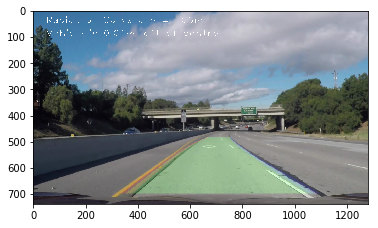

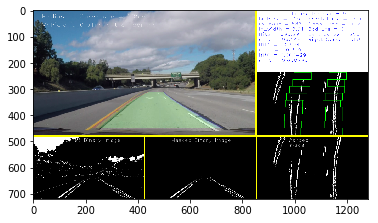

Pair of lanes detected =  1


In [33]:
reset_lanes = True
detected_lines = []

drive_log = open("i_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

image = cv2.imread('test_images/c2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

marked_img = lane_marker_pipeline(image)

showImg(marked_img)
combined_imgs = img_collage(marked_img)
showImg(combined_imgs)
combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
cv2.imwrite('text_test.jpg',combined_imgs)
#drive_log.close()

"""
images = glob.glob('test_images/test1*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
 
"""

print("Pair of lanes detected = ", len(detected_lines))

In [ ]:
marked_img = lane_marker_pipeline(image)
showImg(marked_img)
#drive_log.close()

## Test lane finding pipeline on Videos

This section reads the clips from the video, passes them to the pipeline and creates a video out of the pipeline outputs



In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

## Project Video

Applying lane marking pipeline on project video.

In [29]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("p_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

project_video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("P3.mp4")
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))
drive_log.close()

Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.79366668e-01  -1.50060593e+00   8.73272564e+02]
 [ -2.77555756e-15  -1.90744658e+00   8.53880078e+02]
 [ -4.66206934e-18  -2.37856879e-03   1.00000000e+00]]
Baseline mid, left, center =  640 398 880
Baeline Lane width in pixels =  482
inside first frame
reset final =  False
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                                                                                                                                              | 0/1261 [00:00<?, ?it/s]

reset final =  False


  0%|▏                                                                                                                                                                                                     | 1/1261 [00:00<07:48,  2.69it/s]

reset final =  False


  0%|▎                                                                                                                                                                                                     | 2/1261 [00:00<07:50,  2.67it/s]

reset final =  False


  0%|▍                                                                                                                                                                                                     | 3/1261 [00:01<07:51,  2.67it/s]

reset final =  False


  0%|▋                                                                                                                                                                                                     | 4/1261 [00:01<07:53,  2.66it/s]

reset final =  False


  0%|▊                                                                                                                                                                                                     | 5/1261 [00:01<07:56,  2.64it/s]

reset final =  False


  0%|▉                                                                                                                                                                                                     | 6/1261 [00:02<08:01,  2.61it/s]

reset final =  False


  1%|█                                                                                                                                                                                                     | 7/1261 [00:02<08:03,  2.59it/s]

reset final =  False


  1%|█▎                                                                                                                                                                                                    | 8/1261 [00:03<07:55,  2.64it/s]

reset final =  False


  1%|█▍                                                                                                                                                                                                    | 9/1261 [00:03<07:52,  2.65it/s]

reset final =  False


  1%|█▌                                                                                                                                                                                                   | 10/1261 [00:03<07:47,  2.67it/s]

reset final =  False


  1%|█▋                                                                                                                                                                                                   | 11/1261 [00:04<07:44,  2.69it/s]

reset final =  False


  1%|█▊                                                                                                                                                                                                   | 12/1261 [00:04<07:46,  2.68it/s]

reset final =  False


  1%|██                                                                                                                                                                                                   | 13/1261 [00:04<07:44,  2.69it/s]

reset final =  False


  1%|██▏                                                                                                                                                                                                  | 14/1261 [00:05<08:34,  2.42it/s]

reset final =  False


  1%|██▎                                                                                                                                                                                                  | 15/1261 [00:05<08:18,  2.50it/s]

reset final =  False


  1%|██▍                                                                                                                                                                                                  | 16/1261 [00:06<08:20,  2.49it/s]

reset final =  False


  1%|██▋                                                                                                                                                                                                  | 17/1261 [00:06<08:10,  2.54it/s]

reset final =  False


  1%|██▊                                                                                                                                                                                                  | 18/1261 [00:06<07:58,  2.60it/s]

reset final =  False


  2%|██▉                                                                                                                                                                                                  | 19/1261 [00:07<07:56,  2.61it/s]

reset final =  False


  2%|███                                                                                                                                                                                                  | 20/1261 [00:07<07:51,  2.63it/s]

reset final =  False


  2%|███▎                                                                                                                                                                                                 | 21/1261 [00:08<07:46,  2.66it/s]

reset final =  False


  2%|███▍                                                                                                                                                                                                 | 22/1261 [00:08<07:50,  2.63it/s]

reset final =  False


  2%|███▌                                                                                                                                                                                                 | 23/1261 [00:08<08:06,  2.55it/s]

reset final =  False


  2%|███▋                                                                                                                                                                                                 | 24/1261 [00:09<08:00,  2.58it/s]

reset final =  False


  2%|███▉                                                                                                                                                                                                 | 25/1261 [00:09<07:54,  2.61it/s]

reset final =  False


  2%|████                                                                                                                                                                                                 | 26/1261 [00:09<07:56,  2.59it/s]

reset final =  False


  2%|████▏                                                                                                                                                                                                | 27/1261 [00:10<07:56,  2.59it/s]

reset final =  False


  2%|████▎                                                                                                                                                                                                | 28/1261 [00:10<08:04,  2.55it/s]

reset final =  False


  2%|████▌                                                                                                                                                                                                | 29/1261 [00:11<07:54,  2.60it/s]

reset final =  False


  2%|████▋                                                                                                                                                                                                | 30/1261 [00:11<07:45,  2.65it/s]

reset final =  False


  2%|████▊                                                                                                                                                                                                | 31/1261 [00:11<07:40,  2.67it/s]

reset final =  False


  3%|████▉                                                                                                                                                                                                | 32/1261 [00:12<08:21,  2.45it/s]

reset final =  False


  3%|█████▏                                                                                                                                                                                               | 33/1261 [00:12<08:08,  2.51it/s]

reset final =  False


  3%|█████▎                                                                                                                                                                                               | 34/1261 [00:13<07:54,  2.58it/s]

reset final =  False


  3%|█████▍                                                                                                                                                                                               | 35/1261 [00:13<07:47,  2.62it/s]

reset final =  False


  3%|█████▌                                                                                                                                                                                               | 36/1261 [00:13<07:46,  2.63it/s]

reset final =  False


  3%|█████▊                                                                                                                                                                                               | 37/1261 [00:14<07:34,  2.69it/s]

reset final =  False


  3%|█████▉                                                                                                                                                                                               | 38/1261 [00:14<07:35,  2.68it/s]

reset final =  False


  3%|██████                                                                                                                                                                                               | 39/1261 [00:14<07:30,  2.71it/s]

reset final =  False


  3%|██████▏                                                                                                                                                                                              | 40/1261 [00:15<07:29,  2.72it/s]

reset final =  False


  3%|██████▍                                                                                                                                                                                              | 41/1261 [00:15<07:29,  2.71it/s]

reset final =  False


  3%|██████▌                                                                                                                                                                                              | 42/1261 [00:16<08:18,  2.44it/s]

reset final =  False


  3%|██████▋                                                                                                                                                                                              | 43/1261 [00:16<08:31,  2.38it/s]

reset final =  False


  3%|██████▊                                                                                                                                                                                              | 44/1261 [00:16<08:13,  2.47it/s]

reset final =  False


  4%|███████                                                                                                                                                                                              | 45/1261 [00:17<07:56,  2.55it/s]

reset final =  False


  4%|███████▏                                                                                                                                                                                             | 46/1261 [00:17<07:49,  2.59it/s]

reset final =  False


  4%|███████▎                                                                                                                                                                                             | 47/1261 [00:18<08:22,  2.41it/s]

reset final =  False


  4%|███████▍                                                                                                                                                                                             | 48/1261 [00:18<08:10,  2.47it/s]

reset final =  False


  4%|███████▋                                                                                                                                                                                             | 49/1261 [00:18<08:00,  2.52it/s]

reset final =  False


  4%|███████▊                                                                                                                                                                                             | 50/1261 [00:19<07:50,  2.57it/s]

reset final =  False


  4%|███████▉                                                                                                                                                                                             | 51/1261 [00:19<07:52,  2.56it/s]

reset final =  False


  4%|████████                                                                                                                                                                                             | 52/1261 [00:20<07:46,  2.59it/s]

reset final =  False


  4%|████████▎                                                                                                                                                                                            | 53/1261 [00:20<07:35,  2.65it/s]

reset final =  False


  4%|████████▍                                                                                                                                                                                            | 54/1261 [00:20<07:48,  2.58it/s]

reset final =  False


  4%|████████▌                                                                                                                                                                                            | 55/1261 [00:21<07:42,  2.61it/s]

reset final =  False


  4%|████████▋                                                                                                                                                                                            | 56/1261 [00:21<07:37,  2.63it/s]

reset final =  False


  5%|████████▉                                                                                                                                                                                            | 57/1261 [00:22<07:38,  2.62it/s]

reset final =  False


  5%|█████████                                                                                                                                                                                            | 58/1261 [00:22<07:36,  2.64it/s]

reset final =  False


  5%|█████████▏                                                                                                                                                                                           | 59/1261 [00:22<07:28,  2.68it/s]

reset final =  False


  5%|█████████▎                                                                                                                                                                                           | 60/1261 [00:23<07:26,  2.69it/s]

reset final =  False


  5%|█████████▌                                                                                                                                                                                           | 61/1261 [00:23<07:25,  2.69it/s]

reset final =  False


  5%|█████████▋                                                                                                                                                                                           | 62/1261 [00:23<07:31,  2.66it/s]

reset final =  False


  5%|█████████▊                                                                                                                                                                                           | 63/1261 [00:24<07:38,  2.61it/s]

reset final =  False


  5%|█████████▉                                                                                                                                                                                           | 64/1261 [00:24<07:37,  2.62it/s]

reset final =  False


  5%|██████████▏                                                                                                                                                                                          | 65/1261 [00:25<07:36,  2.62it/s]

reset final =  False


  5%|██████████▎                                                                                                                                                                                          | 66/1261 [00:25<07:30,  2.65it/s]

reset final =  False


  5%|██████████▍                                                                                                                                                                                          | 67/1261 [00:25<07:45,  2.56it/s]

reset final =  False


  5%|██████████▌                                                                                                                                                                                          | 68/1261 [00:26<07:34,  2.62it/s]

reset final =  False


  5%|██████████▊                                                                                                                                                                                          | 69/1261 [00:26<07:33,  2.63it/s]

reset final =  False


  6%|██████████▉                                                                                                                                                                                          | 70/1261 [00:26<07:27,  2.66it/s]

reset final =  False


  6%|███████████                                                                                                                                                                                          | 71/1261 [00:27<07:23,  2.69it/s]

reset final =  False


  6%|███████████▏                                                                                                                                                                                         | 72/1261 [00:27<07:11,  2.76it/s]

reset final =  False


  6%|███████████▍                                                                                                                                                                                         | 73/1261 [00:27<07:13,  2.74it/s]

reset final =  False


  6%|███████████▌                                                                                                                                                                                         | 74/1261 [00:28<07:10,  2.76it/s]

reset final =  False


  6%|███████████▋                                                                                                                                                                                         | 75/1261 [00:28<07:08,  2.77it/s]

reset final =  False


  6%|███████████▊                                                                                                                                                                                         | 76/1261 [00:29<07:06,  2.78it/s]

reset final =  False


  6%|████████████                                                                                                                                                                                         | 77/1261 [00:29<07:09,  2.76it/s]

reset final =  False


  6%|████████████▏                                                                                                                                                                                        | 78/1261 [00:29<07:10,  2.75it/s]

reset final =  False


  6%|████████████▎                                                                                                                                                                                        | 79/1261 [00:30<07:06,  2.77it/s]

reset final =  False


  6%|████████████▍                                                                                                                                                                                        | 80/1261 [00:30<07:05,  2.77it/s]

reset final =  False


  6%|████████████▋                                                                                                                                                                                        | 81/1261 [00:30<07:03,  2.78it/s]

reset final =  False


  7%|████████████▊                                                                                                                                                                                        | 82/1261 [00:31<07:11,  2.74it/s]

reset final =  False


  7%|████████████▉                                                                                                                                                                                        | 83/1261 [00:31<07:23,  2.66it/s]

reset final =  False


  7%|█████████████                                                                                                                                                                                        | 84/1261 [00:32<07:16,  2.69it/s]

reset final =  False


  7%|█████████████▎                                                                                                                                                                                       | 85/1261 [00:32<07:12,  2.72it/s]

reset final =  False


  7%|█████████████▍                                                                                                                                                                                       | 86/1261 [00:32<07:09,  2.73it/s]

reset final =  False


  7%|█████████████▌                                                                                                                                                                                       | 87/1261 [00:33<07:24,  2.64it/s]

reset final =  False


  7%|█████████████▋                                                                                                                                                                                       | 88/1261 [00:33<07:24,  2.64it/s]

reset final =  False


  7%|█████████████▉                                                                                                                                                                                       | 89/1261 [00:33<07:15,  2.69it/s]

reset final =  False


  7%|██████████████                                                                                                                                                                                       | 90/1261 [00:34<07:12,  2.71it/s]

reset final =  False


  7%|██████████████▏                                                                                                                                                                                      | 91/1261 [00:34<07:14,  2.69it/s]

reset final =  False


  7%|██████████████▎                                                                                                                                                                                      | 92/1261 [00:34<07:11,  2.71it/s]

reset final =  False


  7%|██████████████▌                                                                                                                                                                                      | 93/1261 [00:35<07:05,  2.74it/s]

reset final =  False


  7%|██████████████▋                                                                                                                                                                                      | 94/1261 [00:35<07:09,  2.72it/s]

reset final =  False


  8%|██████████████▊                                                                                                                                                                                      | 95/1261 [00:36<07:09,  2.72it/s]

reset final =  False


  8%|██████████████▉                                                                                                                                                                                      | 96/1261 [00:36<07:10,  2.71it/s]

reset final =  False


  8%|███████████████▏                                                                                                                                                                                     | 97/1261 [00:36<07:14,  2.68it/s]

reset final =  False


  8%|███████████████▎                                                                                                                                                                                     | 98/1261 [00:37<07:18,  2.65it/s]

reset final =  False


  8%|███████████████▍                                                                                                                                                                                     | 99/1261 [00:37<07:16,  2.66it/s]

reset final =  False


  8%|███████████████▌                                                                                                                                                                                    | 100/1261 [00:37<07:10,  2.69it/s]

reset final =  False


  8%|███████████████▋                                                                                                                                                                                    | 101/1261 [00:38<07:06,  2.72it/s]

reset final =  False


  8%|███████████████▊                                                                                                                                                                                    | 102/1261 [00:38<07:03,  2.74it/s]

reset final =  False


  8%|████████████████                                                                                                                                                                                    | 103/1261 [00:39<06:59,  2.76it/s]

reset final =  False


  8%|████████████████▏                                                                                                                                                                                   | 104/1261 [00:39<06:58,  2.76it/s]

reset final =  False


  8%|████████████████▎                                                                                                                                                                                   | 105/1261 [00:39<07:04,  2.73it/s]

reset final =  False


  8%|████████████████▍                                                                                                                                                                                   | 106/1261 [00:40<07:53,  2.44it/s]

reset final =  False


  8%|████████████████▋                                                                                                                                                                                   | 107/1261 [00:40<07:49,  2.46it/s]

reset final =  False


  9%|████████████████▊                                                                                                                                                                                   | 108/1261 [00:41<07:42,  2.50it/s]

reset final =  False


  9%|████████████████▉                                                                                                                                                                                   | 109/1261 [00:41<07:27,  2.58it/s]

reset final =  False


  9%|█████████████████                                                                                                                                                                                   | 110/1261 [00:41<07:23,  2.60it/s]

reset final =  False


  9%|█████████████████▎                                                                                                                                                                                  | 111/1261 [00:42<07:12,  2.66it/s]

reset final =  False


  9%|█████████████████▍                                                                                                                                                                                  | 112/1261 [00:42<07:32,  2.54it/s]

reset final =  False


  9%|█████████████████▌                                                                                                                                                                                  | 113/1261 [00:42<07:25,  2.58it/s]

reset final =  False


  9%|█████████████████▋                                                                                                                                                                                  | 114/1261 [00:43<07:19,  2.61it/s]

reset final =  False


  9%|█████████████████▊                                                                                                                                                                                  | 115/1261 [00:43<07:09,  2.67it/s]

reset final =  False


  9%|██████████████████                                                                                                                                                                                  | 116/1261 [00:44<07:07,  2.68it/s]

reset final =  False


  9%|██████████████████▏                                                                                                                                                                                 | 117/1261 [00:44<07:17,  2.61it/s]

reset final =  False


  9%|██████████████████▎                                                                                                                                                                                 | 118/1261 [00:44<07:16,  2.62it/s]

reset final =  False


  9%|██████████████████▍                                                                                                                                                                                 | 119/1261 [00:45<07:08,  2.66it/s]

reset final =  False


 10%|██████████████████▋                                                                                                                                                                                 | 120/1261 [00:45<07:01,  2.71it/s]

reset final =  False


 10%|██████████████████▊                                                                                                                                                                                 | 121/1261 [00:45<06:57,  2.73it/s]

reset final =  False


 10%|██████████████████▉                                                                                                                                                                                 | 122/1261 [00:46<06:56,  2.73it/s]

reset final =  False


 10%|███████████████████                                                                                                                                                                                 | 123/1261 [00:46<06:58,  2.72it/s]

reset final =  False


 10%|███████████████████▎                                                                                                                                                                                | 124/1261 [00:47<06:58,  2.72it/s]

reset final =  False


 10%|███████████████████▍                                                                                                                                                                                | 125/1261 [00:47<07:09,  2.65it/s]

reset final =  False


 10%|███████████████████▌                                                                                                                                                                                | 126/1261 [00:47<07:04,  2.67it/s]

reset final =  False


 10%|███████████████████▋                                                                                                                                                                                | 127/1261 [00:48<07:00,  2.69it/s]

reset final =  False


 10%|███████████████████▉                                                                                                                                                                                | 128/1261 [00:48<07:02,  2.68it/s]

reset final =  False


 10%|████████████████████                                                                                                                                                                                | 129/1261 [00:48<06:57,  2.71it/s]

reset final =  False


 10%|████████████████████▏                                                                                                                                                                               | 130/1261 [00:49<06:55,  2.72it/s]

reset final =  False


 10%|████████████████████▎                                                                                                                                                                               | 131/1261 [00:49<06:50,  2.76it/s]

reset final =  False


 10%|████████████████████▌                                                                                                                                                                               | 132/1261 [00:49<06:47,  2.77it/s]

reset final =  False


 11%|████████████████████▋                                                                                                                                                                               | 133/1261 [00:50<06:48,  2.76it/s]

reset final =  False


 11%|████████████████████▊                                                                                                                                                                               | 134/1261 [00:50<06:46,  2.77it/s]

reset final =  False


 11%|████████████████████▉                                                                                                                                                                               | 135/1261 [00:51<06:46,  2.77it/s]

reset final =  False


 11%|█████████████████████▏                                                                                                                                                                              | 136/1261 [00:51<06:48,  2.75it/s]

reset final =  False


 11%|█████████████████████▎                                                                                                                                                                              | 137/1261 [00:51<06:51,  2.73it/s]

reset final =  False


 11%|█████████████████████▍                                                                                                                                                                              | 138/1261 [00:52<06:49,  2.74it/s]

reset final =  False


 11%|█████████████████████▌                                                                                                                                                                              | 139/1261 [00:52<06:51,  2.73it/s]

reset final =  False


 11%|█████████████████████▊                                                                                                                                                                              | 140/1261 [00:52<06:52,  2.72it/s]

reset final =  False


 11%|█████████████████████▉                                                                                                                                                                              | 141/1261 [00:53<06:58,  2.68it/s]

reset final =  False


 11%|██████████████████████                                                                                                                                                                              | 142/1261 [00:53<07:07,  2.62it/s]

reset final =  False


 11%|██████████████████████▏                                                                                                                                                                             | 143/1261 [00:54<06:59,  2.66it/s]

reset final =  False


 11%|██████████████████████▍                                                                                                                                                                             | 144/1261 [00:54<06:55,  2.69it/s]

reset final =  False


 11%|██████████████████████▌                                                                                                                                                                             | 145/1261 [00:54<06:51,  2.71it/s]

reset final =  False


 12%|██████████████████████▋                                                                                                                                                                             | 146/1261 [00:55<06:46,  2.74it/s]

reset final =  False


 12%|██████████████████████▊                                                                                                                                                                             | 147/1261 [00:55<06:43,  2.76it/s]

reset final =  False


 12%|███████████████████████                                                                                                                                                                             | 148/1261 [00:55<06:46,  2.74it/s]

reset final =  False


 12%|███████████████████████▏                                                                                                                                                                            | 149/1261 [00:56<06:49,  2.72it/s]

reset final =  False


 12%|███████████████████████▎                                                                                                                                                                            | 150/1261 [00:56<06:48,  2.72it/s]

reset final =  False


 12%|███████████████████████▍                                                                                                                                                                            | 151/1261 [00:56<06:49,  2.71it/s]

reset final =  False


 12%|███████████████████████▋                                                                                                                                                                            | 152/1261 [00:57<06:44,  2.74it/s]

reset final =  False


 12%|███████████████████████▊                                                                                                                                                                            | 153/1261 [00:57<06:45,  2.73it/s]

reset final =  False


 12%|███████████████████████▉                                                                                                                                                                            | 154/1261 [00:58<06:46,  2.72it/s]

reset final =  False


 12%|████████████████████████                                                                                                                                                                            | 155/1261 [00:58<06:42,  2.75it/s]

reset final =  False


 12%|████████████████████████▏                                                                                                                                                                           | 156/1261 [00:58<06:44,  2.73it/s]

reset final =  False


 12%|████████████████████████▍                                                                                                                                                                           | 157/1261 [00:59<06:42,  2.75it/s]

reset final =  False


 13%|████████████████████████▌                                                                                                                                                                           | 158/1261 [00:59<07:02,  2.61it/s]

reset final =  False


 13%|████████████████████████▋                                                                                                                                                                           | 159/1261 [00:59<06:58,  2.63it/s]

reset final =  False


 13%|████████████████████████▊                                                                                                                                                                           | 160/1261 [01:00<06:55,  2.65it/s]

reset final =  False


 13%|█████████████████████████                                                                                                                                                                           | 161/1261 [01:00<06:49,  2.69it/s]

reset final =  False


 13%|█████████████████████████▏                                                                                                                                                                          | 162/1261 [01:01<06:45,  2.71it/s]

reset final =  False


 13%|█████████████████████████▎                                                                                                                                                                          | 163/1261 [01:01<06:42,  2.73it/s]

reset final =  False


 13%|█████████████████████████▍                                                                                                                                                                          | 164/1261 [01:01<06:42,  2.73it/s]

reset final =  False


 13%|█████████████████████████▋                                                                                                                                                                          | 165/1261 [01:02<06:41,  2.73it/s]

reset final =  False


 13%|█████████████████████████▊                                                                                                                                                                          | 166/1261 [01:02<06:41,  2.73it/s]

reset final =  False


 13%|█████████████████████████▉                                                                                                                                                                          | 167/1261 [01:02<06:39,  2.74it/s]

reset final =  False


 13%|██████████████████████████                                                                                                                                                                          | 168/1261 [01:03<06:40,  2.73it/s]

reset final =  False


 13%|██████████████████████████▎                                                                                                                                                                         | 169/1261 [01:03<06:42,  2.71it/s]

reset final =  False


 13%|██████████████████████████▍                                                                                                                                                                         | 170/1261 [01:03<06:42,  2.71it/s]

reset final =  False


 14%|██████████████████████████▌                                                                                                                                                                         | 171/1261 [01:04<06:48,  2.67it/s]

reset final =  False


 14%|██████████████████████████▋                                                                                                                                                                         | 172/1261 [01:04<06:51,  2.65it/s]

reset final =  False


 14%|██████████████████████████▉                                                                                                                                                                         | 173/1261 [01:05<06:56,  2.61it/s]

reset final =  False


 14%|███████████████████████████                                                                                                                                                                         | 174/1261 [01:05<06:57,  2.60it/s]

reset final =  False


 14%|███████████████████████████▏                                                                                                                                                                        | 175/1261 [01:05<06:55,  2.61it/s]

reset final =  False


 14%|███████████████████████████▎                                                                                                                                                                        | 176/1261 [01:06<07:24,  2.44it/s]

reset final =  False


 14%|███████████████████████████▌                                                                                                                                                                        | 177/1261 [01:06<07:23,  2.44it/s]

reset final =  False


 14%|███████████████████████████▋                                                                                                                                                                        | 178/1261 [01:07<07:17,  2.48it/s]

reset final =  False


 14%|███████████████████████████▊                                                                                                                                                                        | 179/1261 [01:07<07:04,  2.55it/s]

reset final =  False


 14%|███████████████████████████▉                                                                                                                                                                        | 180/1261 [01:07<06:57,  2.59it/s]

reset final =  False


 14%|████████████████████████████▏                                                                                                                                                                       | 181/1261 [01:08<06:50,  2.63it/s]

reset final =  False


 14%|████████████████████████████▎                                                                                                                                                                       | 182/1261 [01:08<06:44,  2.67it/s]

reset final =  False


 15%|████████████████████████████▍                                                                                                                                                                       | 183/1261 [01:08<06:37,  2.71it/s]

reset final =  False


 15%|████████████████████████████▌                                                                                                                                                                       | 184/1261 [01:09<06:36,  2.72it/s]

reset final =  False


 15%|████████████████████████████▊                                                                                                                                                                       | 185/1261 [01:09<06:35,  2.72it/s]

reset final =  False


 15%|████████████████████████████▉                                                                                                                                                                       | 186/1261 [01:10<06:32,  2.74it/s]

reset final =  False


 15%|█████████████████████████████                                                                                                                                                                       | 187/1261 [01:10<06:33,  2.73it/s]

reset final =  False


 15%|█████████████████████████████▏                                                                                                                                                                      | 188/1261 [01:10<06:31,  2.74it/s]

reset final =  False


 15%|█████████████████████████████▍                                                                                                                                                                      | 189/1261 [01:11<06:32,  2.73it/s]

reset final =  False


 15%|█████████████████████████████▌                                                                                                                                                                      | 190/1261 [01:11<06:33,  2.72it/s]

reset final =  False


 15%|█████████████████████████████▋                                                                                                                                                                      | 191/1261 [01:11<06:30,  2.74it/s]

reset final =  False


 15%|█████████████████████████████▊                                                                                                                                                                      | 192/1261 [01:12<06:29,  2.74it/s]

reset final =  False


 15%|█████████████████████████████▉                                                                                                                                                                      | 193/1261 [01:12<06:58,  2.55it/s]

reset final =  False


 15%|██████████████████████████████▏                                                                                                                                                                     | 194/1261 [01:13<07:02,  2.52it/s]

reset final =  False


 15%|██████████████████████████████▎                                                                                                                                                                     | 195/1261 [01:13<07:06,  2.50it/s]

reset final =  False


 16%|██████████████████████████████▍                                                                                                                                                                     | 196/1261 [01:13<07:08,  2.49it/s]

reset final =  False


 16%|██████████████████████████████▌                                                                                                                                                                     | 197/1261 [01:14<07:14,  2.45it/s]

reset final =  False


 16%|██████████████████████████████▊                                                                                                                                                                     | 198/1261 [01:14<07:00,  2.53it/s]

reset final =  False


 16%|██████████████████████████████▉                                                                                                                                                                     | 199/1261 [01:15<07:14,  2.45it/s]

reset final =  False


 16%|███████████████████████████████                                                                                                                                                                     | 200/1261 [01:15<07:03,  2.51it/s]

reset final =  False


 16%|███████████████████████████████▏                                                                                                                                                                    | 201/1261 [01:15<06:56,  2.55it/s]

reset final =  False


 16%|███████████████████████████████▍                                                                                                                                                                    | 202/1261 [01:16<06:49,  2.59it/s]

reset final =  False


 16%|███████████████████████████████▌                                                                                                                                                                    | 203/1261 [01:16<06:48,  2.59it/s]

reset final =  False


 16%|███████████████████████████████▋                                                                                                                                                                    | 204/1261 [01:17<06:55,  2.55it/s]

reset final =  False


 16%|███████████████████████████████▊                                                                                                                                                                    | 205/1261 [01:17<06:49,  2.58it/s]

reset final =  False


 16%|████████████████████████████████                                                                                                                                                                    | 206/1261 [01:17<06:43,  2.61it/s]

reset final =  False


 16%|████████████████████████████████▏                                                                                                                                                                   | 207/1261 [01:18<06:37,  2.65it/s]

reset final =  False


 16%|████████████████████████████████▎                                                                                                                                                                   | 208/1261 [01:18<06:35,  2.66it/s]

reset final =  False


 17%|████████████████████████████████▍                                                                                                                                                                   | 209/1261 [01:18<06:30,  2.69it/s]

reset final =  False


 17%|████████████████████████████████▋                                                                                                                                                                   | 210/1261 [01:19<06:43,  2.60it/s]

reset final =  False


 17%|████████████████████████████████▊                                                                                                                                                                   | 211/1261 [01:19<06:51,  2.55it/s]

reset final =  False


 17%|████████████████████████████████▉                                                                                                                                                                   | 212/1261 [01:20<06:47,  2.58it/s]

reset final =  False


 17%|█████████████████████████████████                                                                                                                                                                   | 213/1261 [01:20<06:46,  2.58it/s]

reset final =  False


 17%|█████████████████████████████████▎                                                                                                                                                                  | 214/1261 [01:20<06:53,  2.54it/s]

reset final =  False


 17%|█████████████████████████████████▍                                                                                                                                                                  | 215/1261 [01:21<06:59,  2.49it/s]

reset final =  False


 17%|█████████████████████████████████▌                                                                                                                                                                  | 216/1261 [01:21<07:07,  2.44it/s]

reset final =  False


 17%|█████████████████████████████████▋                                                                                                                                                                  | 217/1261 [01:22<06:54,  2.52it/s]

reset final =  False


 17%|█████████████████████████████████▉                                                                                                                                                                  | 218/1261 [01:22<07:07,  2.44it/s]

reset final =  False


 17%|██████████████████████████████████                                                                                                                                                                  | 219/1261 [01:22<06:59,  2.48it/s]

reset final =  False


 17%|██████████████████████████████████▏                                                                                                                                                                 | 220/1261 [01:23<06:51,  2.53it/s]

reset final =  False


 18%|██████████████████████████████████▎                                                                                                                                                                 | 221/1261 [01:23<06:42,  2.58it/s]

reset final =  False


 18%|██████████████████████████████████▌                                                                                                                                                                 | 222/1261 [01:24<06:34,  2.63it/s]

reset final =  False


 18%|██████████████████████████████████▋                                                                                                                                                                 | 223/1261 [01:24<06:55,  2.50it/s]

reset final =  False


 18%|██████████████████████████████████▊                                                                                                                                                                 | 224/1261 [01:24<06:46,  2.55it/s]

reset final =  False


 18%|██████████████████████████████████▉                                                                                                                                                                 | 225/1261 [01:25<06:35,  2.62it/s]

reset final =  False


 18%|███████████████████████████████████▏                                                                                                                                                                | 226/1261 [01:25<06:30,  2.65it/s]

reset final =  False


 18%|███████████████████████████████████▎                                                                                                                                                                | 227/1261 [01:26<06:27,  2.67it/s]

reset final =  False


 18%|███████████████████████████████████▍                                                                                                                                                                | 228/1261 [01:26<06:36,  2.61it/s]

reset final =  False


 18%|███████████████████████████████████▌                                                                                                                                                                | 229/1261 [01:26<06:39,  2.58it/s]

reset final =  False


 18%|███████████████████████████████████▋                                                                                                                                                                | 230/1261 [01:27<06:43,  2.55it/s]

reset final =  False


 18%|███████████████████████████████████▉                                                                                                                                                                | 231/1261 [01:27<06:54,  2.48it/s]

reset final =  False


 18%|████████████████████████████████████                                                                                                                                                                | 232/1261 [01:28<06:50,  2.51it/s]

reset final =  False


 18%|████████████████████████████████████▏                                                                                                                                                               | 233/1261 [01:28<06:40,  2.57it/s]

reset final =  False


 19%|████████████████████████████████████▎                                                                                                                                                               | 234/1261 [01:28<06:56,  2.47it/s]

reset final =  False


 19%|████████████████████████████████████▌                                                                                                                                                               | 235/1261 [01:29<06:57,  2.46it/s]

reset final =  False


 19%|████████████████████████████████████▋                                                                                                                                                               | 236/1261 [01:29<06:48,  2.51it/s]

reset final =  False


 19%|████████████████████████████████████▊                                                                                                                                                               | 237/1261 [01:30<06:39,  2.56it/s]

reset final =  False


 19%|████████████████████████████████████▉                                                                                                                                                               | 238/1261 [01:30<06:33,  2.60it/s]

reset final =  False


 19%|█████████████████████████████████████▏                                                                                                                                                              | 239/1261 [01:30<06:43,  2.54it/s]

reset final =  False


 19%|█████████████████████████████████████▎                                                                                                                                                              | 240/1261 [01:31<06:42,  2.54it/s]

reset final =  False


 19%|█████████████████████████████████████▍                                                                                                                                                              | 241/1261 [01:31<06:34,  2.58it/s]

reset final =  False


 19%|█████████████████████████████████████▌                                                                                                                                                              | 242/1261 [01:31<06:41,  2.54it/s]

reset final =  False


 19%|█████████████████████████████████████▊                                                                                                                                                              | 243/1261 [01:32<06:41,  2.54it/s]

reset final =  False


 19%|█████████████████████████████████████▉                                                                                                                                                              | 244/1261 [01:32<06:46,  2.50it/s]

reset final =  False


 19%|██████████████████████████████████████                                                                                                                                                              | 245/1261 [01:33<06:55,  2.44it/s]

reset final =  False


 20%|██████████████████████████████████████▏                                                                                                                                                             | 246/1261 [01:33<06:50,  2.47it/s]

reset final =  False


 20%|██████████████████████████████████████▍                                                                                                                                                             | 247/1261 [01:34<07:08,  2.37it/s]

reset final =  False


 20%|██████████████████████████████████████▌                                                                                                                                                             | 248/1261 [01:34<07:04,  2.39it/s]

reset final =  False


 20%|██████████████████████████████████████▋                                                                                                                                                             | 249/1261 [01:34<06:51,  2.46it/s]

reset final =  False


 20%|██████████████████████████████████████▊                                                                                                                                                             | 250/1261 [01:35<06:43,  2.51it/s]

reset final =  False


 20%|███████████████████████████████████████                                                                                                                                                             | 251/1261 [01:35<06:43,  2.51it/s]

reset final =  False


 20%|███████████████████████████████████████▏                                                                                                                                                            | 252/1261 [01:36<06:40,  2.52it/s]

reset final =  False


 20%|███████████████████████████████████████▎                                                                                                                                                            | 253/1261 [01:36<06:46,  2.48it/s]

reset final =  False


 20%|███████████████████████████████████████▍                                                                                                                                                            | 254/1261 [01:36<06:50,  2.45it/s]

reset final =  False


 20%|███████████████████████████████████████▋                                                                                                                                                            | 255/1261 [01:37<06:50,  2.45it/s]

reset final =  False


 20%|███████████████████████████████████████▊                                                                                                                                                            | 256/1261 [01:37<07:01,  2.38it/s]

reset final =  False


 20%|███████████████████████████████████████▉                                                                                                                                                            | 257/1261 [01:38<06:52,  2.44it/s]

reset final =  False


 20%|████████████████████████████████████████                                                                                                                                                            | 258/1261 [01:38<06:58,  2.40it/s]

reset final =  False


 21%|████████████████████████████████████████▎                                                                                                                                                           | 259/1261 [01:38<06:52,  2.43it/s]

reset final =  False


 21%|████████████████████████████████████████▍                                                                                                                                                           | 260/1261 [01:39<06:48,  2.45it/s]

reset final =  False


 21%|████████████████████████████████████████▌                                                                                                                                                           | 261/1261 [01:39<06:36,  2.52it/s]

reset final =  False


 21%|████████████████████████████████████████▋                                                                                                                                                           | 262/1261 [01:40<06:46,  2.46it/s]

reset final =  False


 21%|████████████████████████████████████████▉                                                                                                                                                           | 263/1261 [01:40<06:29,  2.56it/s]

reset final =  False


 21%|█████████████████████████████████████████                                                                                                                                                           | 264/1261 [01:40<06:27,  2.57it/s]

reset final =  False


 21%|█████████████████████████████████████████▏                                                                                                                                                          | 265/1261 [01:41<06:23,  2.60it/s]

reset final =  False


 21%|█████████████████████████████████████████▎                                                                                                                                                          | 266/1261 [01:41<06:14,  2.65it/s]

reset final =  False


 21%|█████████████████████████████████████████▌                                                                                                                                                          | 267/1261 [01:41<06:12,  2.67it/s]

reset final =  False


 21%|█████████████████████████████████████████▋                                                                                                                                                          | 268/1261 [01:42<06:14,  2.65it/s]

reset final =  False


 21%|█████████████████████████████████████████▊                                                                                                                                                          | 269/1261 [01:42<06:12,  2.66it/s]

reset final =  False


 21%|█████████████████████████████████████████▉                                                                                                                                                          | 270/1261 [01:43<06:16,  2.63it/s]

reset final =  False


 21%|██████████████████████████████████████████                                                                                                                                                          | 271/1261 [01:43<06:22,  2.59it/s]

reset final =  False


 22%|██████████████████████████████████████████▎                                                                                                                                                         | 272/1261 [01:44<06:49,  2.41it/s]

reset final =  False


 22%|██████████████████████████████████████████▍                                                                                                                                                         | 273/1261 [01:44<06:40,  2.46it/s]

reset final =  False


 22%|██████████████████████████████████████████▌                                                                                                                                                         | 274/1261 [01:44<06:31,  2.52it/s]

reset final =  False


 22%|██████████████████████████████████████████▋                                                                                                                                                         | 275/1261 [01:45<06:20,  2.59it/s]

reset final =  False


 22%|██████████████████████████████████████████▉                                                                                                                                                         | 276/1261 [01:45<06:14,  2.63it/s]

reset final =  False


 22%|███████████████████████████████████████████                                                                                                                                                         | 277/1261 [01:45<06:10,  2.66it/s]

reset final =  False


 22%|███████████████████████████████████████████▏                                                                                                                                                        | 278/1261 [01:46<06:05,  2.69it/s]

reset final =  False


 22%|███████████████████████████████████████████▎                                                                                                                                                        | 279/1261 [01:46<06:01,  2.71it/s]

reset final =  False


 22%|███████████████████████████████████████████▌                                                                                                                                                        | 280/1261 [01:46<06:06,  2.68it/s]

reset final =  False


 22%|███████████████████████████████████████████▋                                                                                                                                                        | 281/1261 [01:47<06:05,  2.68it/s]

reset final =  False


 22%|███████████████████████████████████████████▊                                                                                                                                                        | 282/1261 [01:47<06:04,  2.69it/s]

reset final =  False


 22%|███████████████████████████████████████████▉                                                                                                                                                        | 283/1261 [01:48<06:07,  2.66it/s]

reset final =  False


 23%|████████████████████████████████████████████▏                                                                                                                                                       | 284/1261 [01:48<06:15,  2.60it/s]

reset final =  False


 23%|████████████████████████████████████████████▎                                                                                                                                                       | 285/1261 [01:48<06:27,  2.52it/s]

reset final =  False


 23%|████████████████████████████████████████████▍                                                                                                                                                       | 286/1261 [01:49<06:22,  2.55it/s]

reset final =  False


 23%|████████████████████████████████████████████▌                                                                                                                                                       | 287/1261 [01:49<06:12,  2.62it/s]

reset final =  False


 23%|████████████████████████████████████████████▊                                                                                                                                                       | 288/1261 [01:50<06:08,  2.64it/s]

reset final =  False


 23%|████████████████████████████████████████████▉                                                                                                                                                       | 289/1261 [01:50<06:05,  2.66it/s]

reset final =  False


 23%|█████████████████████████████████████████████                                                                                                                                                       | 290/1261 [01:50<06:03,  2.67it/s]

reset final =  False


 23%|█████████████████████████████████████████████▏                                                                                                                                                      | 291/1261 [01:51<05:58,  2.70it/s]

reset final =  False


 23%|█████████████████████████████████████████████▍                                                                                                                                                      | 292/1261 [01:51<05:56,  2.72it/s]

reset final =  False


 23%|█████████████████████████████████████████████▌                                                                                                                                                      | 293/1261 [01:51<05:59,  2.69it/s]

reset final =  False


 23%|█████████████████████████████████████████████▋                                                                                                                                                      | 294/1261 [01:52<05:59,  2.69it/s]

reset final =  False


 23%|█████████████████████████████████████████████▊                                                                                                                                                      | 295/1261 [01:52<05:59,  2.69it/s]

reset final =  False


 23%|██████████████████████████████████████████████                                                                                                                                                      | 296/1261 [01:52<05:56,  2.70it/s]

reset final =  False


 24%|██████████████████████████████████████████████▏                                                                                                                                                     | 297/1261 [01:53<06:04,  2.64it/s]

reset final =  False


 24%|██████████████████████████████████████████████▎                                                                                                                                                     | 298/1261 [01:53<06:15,  2.57it/s]

reset final =  False


 24%|██████████████████████████████████████████████▍                                                                                                                                                     | 299/1261 [01:54<06:04,  2.64it/s]

reset final =  False


 24%|██████████████████████████████████████████████▋                                                                                                                                                     | 300/1261 [01:54<06:05,  2.63it/s]

reset final =  False


 24%|██████████████████████████████████████████████▊                                                                                                                                                     | 301/1261 [01:54<06:03,  2.64it/s]

reset final =  False


 24%|██████████████████████████████████████████████▉                                                                                                                                                     | 302/1261 [01:55<06:24,  2.50it/s]

reset final =  False


 24%|███████████████████████████████████████████████                                                                                                                                                     | 303/1261 [01:55<06:32,  2.44it/s]

reset final =  False


 24%|███████████████████████████████████████████████▎                                                                                                                                                    | 304/1261 [01:56<06:28,  2.46it/s]

reset final =  False


 24%|███████████████████████████████████████████████▍                                                                                                                                                    | 305/1261 [01:56<06:26,  2.47it/s]

reset final =  False


 24%|███████████████████████████████████████████████▌                                                                                                                                                    | 306/1261 [01:56<06:24,  2.49it/s]

reset final =  False


 24%|███████████████████████████████████████████████▋                                                                                                                                                    | 307/1261 [01:57<06:22,  2.49it/s]

reset final =  False


 24%|███████████████████████████████████████████████▊                                                                                                                                                    | 308/1261 [01:57<06:22,  2.49it/s]

reset final =  False


 25%|████████████████████████████████████████████████                                                                                                                                                    | 309/1261 [01:58<06:18,  2.51it/s]

reset final =  False


 25%|████████████████████████████████████████████████▏                                                                                                                                                   | 310/1261 [01:58<06:19,  2.51it/s]

reset final =  False


 25%|████████████████████████████████████████████████▎                                                                                                                                                   | 311/1261 [01:58<06:19,  2.50it/s]

reset final =  False


 25%|████████████████████████████████████████████████▍                                                                                                                                                   | 312/1261 [01:59<06:25,  2.46it/s]

reset final =  False


 25%|████████████████████████████████████████████████▋                                                                                                                                                   | 313/1261 [01:59<06:34,  2.40it/s]

reset final =  False


 25%|████████████████████████████████████████████████▊                                                                                                                                                   | 314/1261 [02:00<06:22,  2.47it/s]

reset final =  False


 25%|████████████████████████████████████████████████▉                                                                                                                                                   | 315/1261 [02:00<06:12,  2.54it/s]

reset final =  False


 25%|█████████████████████████████████████████████████                                                                                                                                                   | 316/1261 [02:00<06:05,  2.59it/s]

reset final =  False


 25%|█████████████████████████████████████████████████▎                                                                                                                                                  | 317/1261 [02:01<06:24,  2.46it/s]

reset final =  False


 25%|█████████████████████████████████████████████████▍                                                                                                                                                  | 318/1261 [02:01<06:13,  2.53it/s]

reset final =  False


 25%|█████████████████████████████████████████████████▌                                                                                                                                                  | 319/1261 [02:02<06:07,  2.57it/s]

reset final =  False


 25%|█████████████████████████████████████████████████▋                                                                                                                                                  | 320/1261 [02:02<05:59,  2.61it/s]

reset final =  False


 25%|█████████████████████████████████████████████████▉                                                                                                                                                  | 321/1261 [02:02<05:55,  2.64it/s]

reset final =  False


 26%|██████████████████████████████████████████████████                                                                                                                                                  | 322/1261 [02:03<05:51,  2.67it/s]

reset final =  False


 26%|██████████████████████████████████████████████████▏                                                                                                                                                 | 323/1261 [02:03<05:48,  2.69it/s]

reset final =  False


 26%|██████████████████████████████████████████████████▎                                                                                                                                                 | 324/1261 [02:03<05:49,  2.68it/s]

reset final =  False


 26%|██████████████████████████████████████████████████▌                                                                                                                                                 | 325/1261 [02:04<05:48,  2.68it/s]

reset final =  False


 26%|██████████████████████████████████████████████████▋                                                                                                                                                 | 326/1261 [02:04<05:46,  2.70it/s]

reset final =  False


 26%|██████████████████████████████████████████████████▊                                                                                                                                                 | 327/1261 [02:05<05:41,  2.74it/s]

reset final =  False


 26%|██████████████████████████████████████████████████▉                                                                                                                                                 | 328/1261 [02:05<05:45,  2.70it/s]

reset final =  False


 26%|███████████████████████████████████████████████████▏                                                                                                                                                | 329/1261 [02:05<05:46,  2.69it/s]

reset final =  False


 26%|███████████████████████████████████████████████████▎                                                                                                                                                | 330/1261 [02:06<05:44,  2.70it/s]

reset final =  False


 26%|███████████████████████████████████████████████████▍                                                                                                                                                | 331/1261 [02:06<05:44,  2.70it/s]

reset final =  False


 26%|███████████████████████████████████████████████████▌                                                                                                                                                | 332/1261 [02:06<05:38,  2.74it/s]

reset final =  False


 26%|███████████████████████████████████████████████████▊                                                                                                                                                | 333/1261 [02:07<05:42,  2.71it/s]

reset final =  False


 26%|███████████████████████████████████████████████████▉                                                                                                                                                | 334/1261 [02:07<05:39,  2.73it/s]

reset final =  False


 27%|████████████████████████████████████████████████████                                                                                                                                                | 335/1261 [02:08<05:43,  2.70it/s]

reset final =  False


 27%|████████████████████████████████████████████████████▏                                                                                                                                               | 336/1261 [02:08<05:40,  2.71it/s]

reset final =  False


 27%|████████████████████████████████████████████████████▍                                                                                                                                               | 337/1261 [02:08<05:40,  2.71it/s]

reset final =  False


 27%|████████████████████████████████████████████████████▌                                                                                                                                               | 338/1261 [02:09<05:38,  2.72it/s]

reset final =  False


 27%|████████████████████████████████████████████████████▋                                                                                                                                               | 339/1261 [02:09<05:38,  2.72it/s]

reset final =  False


 27%|████████████████████████████████████████████████████▊                                                                                                                                               | 340/1261 [02:09<05:36,  2.74it/s]

reset final =  False


 27%|█████████████████████████████████████████████████████                                                                                                                                               | 341/1261 [02:10<05:37,  2.73it/s]

reset final =  False


 27%|█████████████████████████████████████████████████████▏                                                                                                                                              | 342/1261 [02:10<05:32,  2.76it/s]

reset final =  False


 27%|█████████████████████████████████████████████████████▎                                                                                                                                              | 343/1261 [02:10<05:39,  2.70it/s]

reset final =  False


 27%|█████████████████████████████████████████████████████▍                                                                                                                                              | 344/1261 [02:11<05:37,  2.72it/s]

reset final =  False


 27%|█████████████████████████████████████████████████████▌                                                                                                                                              | 345/1261 [02:11<05:40,  2.69it/s]

reset final =  False


 27%|█████████████████████████████████████████████████████▊                                                                                                                                              | 346/1261 [02:12<05:38,  2.70it/s]

reset final =  False


 28%|█████████████████████████████████████████████████████▉                                                                                                                                              | 347/1261 [02:12<05:38,  2.70it/s]

reset final =  False


 28%|██████████████████████████████████████████████████████                                                                                                                                              | 348/1261 [02:12<05:32,  2.75it/s]

reset final =  False


 28%|██████████████████████████████████████████████████████▏                                                                                                                                             | 349/1261 [02:13<05:37,  2.70it/s]

reset final =  False


 28%|██████████████████████████████████████████████████████▍                                                                                                                                             | 350/1261 [02:13<05:37,  2.70it/s]

reset final =  False


 28%|██████████████████████████████████████████████████████▌                                                                                                                                             | 351/1261 [02:13<05:34,  2.72it/s]

reset final =  False


 28%|██████████████████████████████████████████████████████▋                                                                                                                                             | 352/1261 [02:14<05:37,  2.70it/s]

reset final =  False


 28%|██████████████████████████████████████████████████████▊                                                                                                                                             | 353/1261 [02:14<05:31,  2.74it/s]

reset final =  False


 28%|███████████████████████████████████████████████████████                                                                                                                                             | 354/1261 [02:15<05:35,  2.70it/s]

reset final =  False


 28%|███████████████████████████████████████████████████████▏                                                                                                                                            | 355/1261 [02:15<05:33,  2.72it/s]

reset final =  False


 28%|███████████████████████████████████████████████████████▎                                                                                                                                            | 356/1261 [02:15<05:33,  2.72it/s]

reset final =  False


 28%|███████████████████████████████████████████████████████▍                                                                                                                                            | 357/1261 [02:16<05:31,  2.73it/s]

reset final =  False


 28%|███████████████████████████████████████████████████████▋                                                                                                                                            | 358/1261 [02:16<05:28,  2.75it/s]

reset final =  False


 28%|███████████████████████████████████████████████████████▊                                                                                                                                            | 359/1261 [02:16<05:33,  2.71it/s]

reset final =  False


 29%|███████████████████████████████████████████████████████▉                                                                                                                                            | 360/1261 [02:17<05:32,  2.71it/s]

reset final =  False


 29%|████████████████████████████████████████████████████████                                                                                                                                            | 361/1261 [02:17<05:32,  2.71it/s]

reset final =  False


 29%|████████████████████████████████████████████████████████▎                                                                                                                                           | 362/1261 [02:17<05:34,  2.69it/s]

reset final =  False


 29%|████████████████████████████████████████████████████████▍                                                                                                                                           | 363/1261 [02:18<05:34,  2.69it/s]

reset final =  False


 29%|████████████████████████████████████████████████████████▌                                                                                                                                           | 364/1261 [02:18<05:28,  2.73it/s]

reset final =  False


 29%|████████████████████████████████████████████████████████▋                                                                                                                                           | 365/1261 [02:19<05:29,  2.72it/s]

reset final =  False


 29%|████████████████████████████████████████████████████████▉                                                                                                                                           | 366/1261 [02:19<05:29,  2.71it/s]

reset final =  False


 29%|█████████████████████████████████████████████████████████                                                                                                                                           | 367/1261 [02:19<05:28,  2.72it/s]

reset final =  False


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                          | 368/1261 [02:20<05:28,  2.72it/s]

reset final =  False


 29%|█████████████████████████████████████████████████████████▎                                                                                                                                          | 369/1261 [02:20<05:27,  2.72it/s]

reset final =  False


 29%|█████████████████████████████████████████████████████████▌                                                                                                                                          | 370/1261 [02:20<05:23,  2.76it/s]

reset final =  False


 29%|█████████████████████████████████████████████████████████▋                                                                                                                                          | 371/1261 [02:21<05:28,  2.71it/s]

reset final =  False


 30%|█████████████████████████████████████████████████████████▊                                                                                                                                          | 372/1261 [02:21<05:28,  2.71it/s]

reset final =  False


 30%|█████████████████████████████████████████████████████████▉                                                                                                                                          | 373/1261 [02:22<05:28,  2.70it/s]

reset final =  False


 30%|██████████████████████████████████████████████████████████▏                                                                                                                                         | 374/1261 [02:22<05:22,  2.75it/s]

reset final =  False


 30%|██████████████████████████████████████████████████████████▎                                                                                                                                         | 375/1261 [02:22<05:22,  2.75it/s]

reset final =  False


 30%|██████████████████████████████████████████████████████████▍                                                                                                                                         | 376/1261 [02:23<05:27,  2.70it/s]

reset final =  False


 30%|██████████████████████████████████████████████████████████▌                                                                                                                                         | 377/1261 [02:23<05:28,  2.69it/s]

reset final =  False


 30%|██████████████████████████████████████████████████████████▊                                                                                                                                         | 378/1261 [02:23<05:26,  2.70it/s]

reset final =  False


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                         | 379/1261 [02:24<05:28,  2.68it/s]

reset final =  False


 30%|███████████████████████████████████████████████████████████                                                                                                                                         | 380/1261 [02:24<05:27,  2.69it/s]

reset final =  False


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                        | 381/1261 [02:24<05:22,  2.72it/s]

reset final =  False


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                        | 382/1261 [02:25<05:24,  2.71it/s]

reset final =  False


 30%|███████████████████████████████████████████████████████████▌                                                                                                                                        | 383/1261 [02:25<05:25,  2.70it/s]

reset final =  False


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                        | 384/1261 [02:26<05:26,  2.69it/s]

reset final =  False


 31%|███████████████████████████████████████████████████████████▊                                                                                                                                        | 385/1261 [02:26<05:26,  2.68it/s]

reset final =  False


 31%|███████████████████████████████████████████████████████████▉                                                                                                                                        | 386/1261 [02:26<05:26,  2.68it/s]

reset final =  False


 31%|████████████████████████████████████████████████████████████▏                                                                                                                                       | 387/1261 [02:27<05:23,  2.70it/s]

reset final =  False


 31%|████████████████████████████████████████████████████████████▎                                                                                                                                       | 388/1261 [02:27<05:20,  2.72it/s]

reset final =  False


 31%|████████████████████████████████████████████████████████████▍                                                                                                                                       | 389/1261 [02:27<05:22,  2.70it/s]

reset final =  False


 31%|████████████████████████████████████████████████████████████▌                                                                                                                                       | 390/1261 [02:28<05:21,  2.71it/s]

reset final =  False


 31%|████████████████████████████████████████████████████████████▊                                                                                                                                       | 391/1261 [02:28<05:18,  2.74it/s]

reset final =  False


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                       | 392/1261 [02:29<05:21,  2.70it/s]

reset final =  False


 31%|█████████████████████████████████████████████████████████████                                                                                                                                       | 393/1261 [02:29<05:22,  2.69it/s]

reset final =  False


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                      | 394/1261 [02:29<05:20,  2.71it/s]

reset final =  False


 31%|█████████████████████████████████████████████████████████████▍                                                                                                                                      | 395/1261 [02:30<05:23,  2.68it/s]

reset final =  False


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                      | 396/1261 [02:30<05:20,  2.70it/s]

reset final =  False


 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                      | 397/1261 [02:30<05:14,  2.75it/s]

reset final =  False


 32%|█████████████████████████████████████████████████████████████▊                                                                                                                                      | 398/1261 [02:31<05:17,  2.72it/s]

reset final =  False


 32%|██████████████████████████████████████████████████████████████                                                                                                                                      | 399/1261 [02:31<05:17,  2.72it/s]

reset final =  False


 32%|██████████████████████████████████████████████████████████████▏                                                                                                                                     | 400/1261 [02:32<05:18,  2.70it/s]

reset final =  False


 32%|██████████████████████████████████████████████████████████████▎                                                                                                                                     | 401/1261 [02:32<05:19,  2.69it/s]

reset final =  False


 32%|██████████████████████████████████████████████████████████████▍                                                                                                                                     | 402/1261 [02:32<05:12,  2.75it/s]

reset final =  False


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 403/1261 [02:33<05:18,  2.69it/s]

reset final =  False


 32%|██████████████████████████████████████████████████████████████▊                                                                                                                                     | 404/1261 [02:33<05:14,  2.72it/s]

reset final =  False


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                     | 405/1261 [02:33<05:17,  2.69it/s]

reset final =  False


 32%|███████████████████████████████████████████████████████████████                                                                                                                                     | 406/1261 [02:34<05:16,  2.70it/s]

reset final =  False


 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                    | 407/1261 [02:34<05:19,  2.67it/s]

reset final =  True


 32%|███████████████████████████████████████████████████████████████▍                                                                                                                                    | 408/1261 [02:34<05:17,  2.69it/s]

reset final =  True


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                    | 409/1261 [02:35<05:18,  2.68it/s]

reset final =  False


 33%|███████████████████████████████████████████████████████████████▋                                                                                                                                    | 410/1261 [02:35<05:21,  2.64it/s]

reset final =  False


 33%|███████████████████████████████████████████████████████████████▉                                                                                                                                    | 411/1261 [02:36<05:19,  2.66it/s]

reset final =  False


 33%|████████████████████████████████████████████████████████████████                                                                                                                                    | 412/1261 [02:36<05:18,  2.66it/s]

reset final =  False


 33%|████████████████████████████████████████████████████████████████▏                                                                                                                                   | 413/1261 [02:36<05:16,  2.68it/s]

reset final =  False


 33%|████████████████████████████████████████████████████████████████▎                                                                                                                                   | 414/1261 [02:37<05:16,  2.68it/s]

reset final =  False


 33%|████████████████████████████████████████████████████████████████▌                                                                                                                                   | 415/1261 [02:37<05:14,  2.69it/s]

reset final =  False


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                   | 416/1261 [02:37<05:15,  2.68it/s]

reset final =  False


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                   | 417/1261 [02:38<05:13,  2.69it/s]

reset final =  False


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                   | 418/1261 [02:38<05:15,  2.67it/s]

reset final =  False


 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                  | 419/1261 [02:39<05:14,  2.67it/s]

reset final =  False


 33%|█████████████████████████████████████████████████████████████████▎                                                                                                                                  | 420/1261 [02:39<05:08,  2.72it/s]

reset final =  False


 33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                  | 421/1261 [02:39<05:09,  2.72it/s]

reset final =  False


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                  | 422/1261 [02:40<05:29,  2.55it/s]

reset final =  False


 34%|█████████████████████████████████████████████████████████████████▋                                                                                                                                  | 423/1261 [02:40<05:21,  2.61it/s]

reset final =  False


 34%|█████████████████████████████████████████████████████████████████▉                                                                                                                                  | 424/1261 [02:41<05:22,  2.60it/s]

reset final =  False


 34%|██████████████████████████████████████████████████████████████████                                                                                                                                  | 425/1261 [02:41<05:19,  2.62it/s]

reset final =  False


 34%|██████████████████████████████████████████████████████████████████▏                                                                                                                                 | 426/1261 [02:41<05:17,  2.63it/s]

reset final =  False


 34%|██████████████████████████████████████████████████████████████████▎                                                                                                                                 | 427/1261 [02:42<05:13,  2.66it/s]

reset final =  False


 34%|██████████████████████████████████████████████████████████████████▌                                                                                                                                 | 428/1261 [02:42<05:09,  2.69it/s]

reset final =  False


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 429/1261 [02:42<05:12,  2.66it/s]

reset final =  False


 34%|██████████████████████████████████████████████████████████████████▊                                                                                                                                 | 430/1261 [02:43<05:08,  2.70it/s]

reset final =  False


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                 | 431/1261 [02:43<05:12,  2.66it/s]

reset final =  False


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                | 432/1261 [02:44<05:11,  2.66it/s]

reset final =  False


 34%|███████████████████████████████████████████████████████████████████▎                                                                                                                                | 433/1261 [02:44<05:09,  2.68it/s]

reset final =  False


 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                | 434/1261 [02:44<05:08,  2.68it/s]

reset final =  False


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                | 435/1261 [02:45<05:09,  2.67it/s]

reset final =  False


 35%|███████████████████████████████████████████████████████████████████▊                                                                                                                                | 436/1261 [02:45<05:08,  2.68it/s]

reset final =  False


 35%|███████████████████████████████████████████████████████████████████▉                                                                                                                                | 437/1261 [02:45<05:06,  2.69it/s]

reset final =  False


 35%|████████████████████████████████████████████████████████████████████                                                                                                                                | 438/1261 [02:46<05:05,  2.70it/s]

reset final =  False


 35%|████████████████████████████████████████████████████████████████████▏                                                                                                                               | 439/1261 [02:46<05:05,  2.69it/s]

reset final =  False


 35%|████████████████████████████████████████████████████████████████████▍                                                                                                                               | 440/1261 [02:46<05:00,  2.73it/s]

reset final =  False


 35%|████████████████████████████████████████████████████████████████████▌                                                                                                                               | 441/1261 [02:47<05:02,  2.71it/s]

reset final =  False


 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                               | 442/1261 [02:47<05:05,  2.68it/s]

reset final =  False


 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                               | 443/1261 [02:48<05:09,  2.64it/s]

reset final =  False


 35%|█████████████████████████████████████████████████████████████████████                                                                                                                               | 444/1261 [02:48<05:10,  2.63it/s]

reset final =  False


 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                              | 445/1261 [02:48<05:15,  2.59it/s]

reset final =  False


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                              | 446/1261 [02:49<05:14,  2.59it/s]

reset final =  False


 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                              | 447/1261 [02:49<05:17,  2.56it/s]

reset final =  False


 36%|█████████████████████████████████████████████████████████████████████▋                                                                                                                              | 448/1261 [02:50<05:18,  2.55it/s]

reset final =  False


 36%|█████████████████████████████████████████████████████████████████████▊                                                                                                                              | 449/1261 [02:50<05:22,  2.51it/s]

reset final =  False


 36%|█████████████████████████████████████████████████████████████████████▉                                                                                                                              | 450/1261 [02:50<05:22,  2.51it/s]

reset final =  False


 36%|██████████████████████████████████████████████████████████████████████                                                                                                                              | 451/1261 [02:51<05:21,  2.52it/s]

reset final =  False


 36%|██████████████████████████████████████████████████████████████████████▎                                                                                                                             | 452/1261 [02:51<05:20,  2.52it/s]

reset final =  False


 36%|██████████████████████████████████████████████████████████████████████▍                                                                                                                             | 453/1261 [02:52<05:18,  2.54it/s]

reset final =  False


 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                             | 454/1261 [02:52<05:16,  2.55it/s]

reset final =  False


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                             | 455/1261 [02:52<05:15,  2.56it/s]

reset final =  False


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                             | 456/1261 [02:53<05:17,  2.54it/s]

reset final =  False


 36%|███████████████████████████████████████████████████████████████████████                                                                                                                             | 457/1261 [02:53<05:15,  2.54it/s]

reset final =  False


 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                            | 458/1261 [02:54<05:15,  2.55it/s]

reset final =  False


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                            | 459/1261 [02:54<05:14,  2.55it/s]

reset final =  False


 36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                            | 460/1261 [02:54<05:15,  2.54it/s]

reset final =  False


 37%|███████████████████████████████████████████████████████████████████████▋                                                                                                                            | 461/1261 [02:55<05:16,  2.53it/s]

reset final =  False


 37%|███████████████████████████████████████████████████████████████████████▊                                                                                                                            | 462/1261 [02:55<05:12,  2.56it/s]

reset final =  False


 37%|███████████████████████████████████████████████████████████████████████▉                                                                                                                            | 463/1261 [02:55<05:14,  2.54it/s]

reset final =  False


 37%|████████████████████████████████████████████████████████████████████████                                                                                                                            | 464/1261 [02:56<05:14,  2.53it/s]

reset final =  False


 37%|████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 465/1261 [02:56<05:15,  2.52it/s]

reset final =  False


 37%|████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 466/1261 [02:57<05:17,  2.51it/s]

reset final =  False


 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 467/1261 [02:57<05:17,  2.50it/s]

reset final =  False


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 468/1261 [02:57<05:14,  2.52it/s]

reset final =  False


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 469/1261 [02:58<05:14,  2.52it/s]

reset final =  False


 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                           | 470/1261 [02:58<05:08,  2.57it/s]

reset final =  False


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 471/1261 [02:59<05:08,  2.56it/s]

reset final =  False


 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 472/1261 [02:59<05:00,  2.62it/s]

reset final =  False


 38%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 473/1261 [02:59<05:01,  2.62it/s]

reset final =  False


 38%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 474/1261 [03:00<05:06,  2.57it/s]

reset final =  False


 38%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 475/1261 [03:00<05:08,  2.55it/s]

reset final =  False


 38%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 476/1261 [03:01<05:04,  2.58it/s]

reset final =  False


 38%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 477/1261 [03:01<05:05,  2.57it/s]

reset final =  False


 38%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 478/1261 [03:01<05:06,  2.55it/s]

reset final =  False


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 479/1261 [03:02<05:09,  2.53it/s]

reset final =  False


 38%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 480/1261 [03:02<05:10,  2.51it/s]

reset final =  False


 38%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 481/1261 [03:03<05:11,  2.50it/s]

reset final =  False


 38%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 482/1261 [03:03<05:14,  2.48it/s]

reset final =  False


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                         | 483/1261 [03:03<05:13,  2.48it/s]

reset final =  False


 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 484/1261 [03:04<05:09,  2.51it/s]

reset final =  False


 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 485/1261 [03:04<05:12,  2.48it/s]

reset final =  False


 39%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 486/1261 [03:05<05:13,  2.47it/s]

reset final =  False


 39%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 487/1261 [03:05<05:13,  2.47it/s]

reset final =  False


 39%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 488/1261 [03:05<05:15,  2.45it/s]

reset final =  False


 39%|████████████████████████████████████████████████████████████████████████████                                                                                                                        | 489/1261 [03:06<05:07,  2.51it/s]

reset final =  False


 39%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 490/1261 [03:06<05:02,  2.55it/s]

reset final =  False


 39%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 491/1261 [03:07<04:58,  2.58it/s]

reset final =  False


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 492/1261 [03:07<05:10,  2.48it/s]

reset final =  True


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 493/1261 [03:07<05:12,  2.46it/s]

reset final =  True


 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 494/1261 [03:08<05:08,  2.49it/s]

reset final =  True


 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 495/1261 [03:08<05:05,  2.50it/s]

reset final =  True


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                       | 496/1261 [03:09<05:04,  2.51it/s]

reset final =  True


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 497/1261 [03:09<05:01,  2.54it/s]

reset final =  True


 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 498/1261 [03:09<04:58,  2.56it/s]

reset final =  False


 40%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 499/1261 [03:10<04:59,  2.54it/s]

reset final =  False


 40%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 500/1261 [03:10<04:57,  2.56it/s]

reset final =  False


 40%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 501/1261 [03:11<05:03,  2.51it/s]

reset final =  False


 40%|██████████████████████████████████████████████████████████████████████████████                                                                                                                      | 502/1261 [03:11<05:00,  2.52it/s]

reset final =  False


 40%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 503/1261 [03:11<04:59,  2.53it/s]

reset final =  False


 40%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 504/1261 [03:12<04:55,  2.56it/s]

reset final =  False


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 505/1261 [03:12<04:51,  2.60it/s]

reset final =  False


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 506/1261 [03:12<04:47,  2.63it/s]

reset final =  False


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 507/1261 [03:13<04:43,  2.66it/s]

reset final =  False


 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 508/1261 [03:13<04:45,  2.64it/s]

reset final =  False


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                     | 509/1261 [03:14<04:41,  2.67it/s]

reset final =  False


 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 510/1261 [03:14<04:43,  2.65it/s]

reset final =  False


 41%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 511/1261 [03:14<04:42,  2.65it/s]

reset final =  False


 41%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 512/1261 [03:15<04:42,  2.65it/s]

reset final =  False


 41%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 513/1261 [03:15<04:40,  2.66it/s]

reset final =  False


 41%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 514/1261 [03:15<04:37,  2.70it/s]

reset final =  False


 41%|████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 515/1261 [03:16<04:41,  2.65it/s]

reset final =  False


 41%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 516/1261 [03:16<04:57,  2.51it/s]

reset final =  False


 41%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 517/1261 [03:17<04:51,  2.55it/s]

reset final =  False


 41%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 518/1261 [03:17<04:47,  2.59it/s]

reset final =  False


 41%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 519/1261 [03:17<04:53,  2.53it/s]

reset final =  False


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 520/1261 [03:18<04:51,  2.54it/s]

reset final =  False


 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 521/1261 [03:18<04:56,  2.50it/s]

reset final =  False


 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 522/1261 [03:19<04:46,  2.57it/s]

reset final =  False


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 523/1261 [03:19<05:03,  2.43it/s]

reset final =  False


 42%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 524/1261 [03:19<04:57,  2.48it/s]

reset final =  False


 42%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 525/1261 [03:20<04:51,  2.52it/s]

reset final =  False


 42%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 526/1261 [03:20<04:48,  2.55it/s]

reset final =  False


 42%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 527/1261 [03:21<04:53,  2.50it/s]

reset final =  False


 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 528/1261 [03:21<04:56,  2.47it/s]

reset final =  False


 42%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 529/1261 [03:21<04:50,  2.52it/s]

reset final =  False


 42%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 530/1261 [03:22<04:44,  2.57it/s]

reset final =  False


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 531/1261 [03:22<04:42,  2.59it/s]

reset final =  False


 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 532/1261 [03:23<04:50,  2.51it/s]

reset final =  False


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 533/1261 [03:23<04:42,  2.58it/s]

reset final =  False


 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 534/1261 [03:23<04:38,  2.62it/s]

reset final =  False


 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 535/1261 [03:24<04:35,  2.64it/s]

reset final =  False


 43%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 536/1261 [03:24<04:33,  2.65it/s]

reset final =  False


 43%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 537/1261 [03:24<04:31,  2.67it/s]

reset final =  False


 43%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 538/1261 [03:25<04:29,  2.68it/s]

reset final =  False


 43%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 539/1261 [03:25<04:31,  2.66it/s]

reset final =  False


 43%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 540/1261 [03:26<04:28,  2.68it/s]

reset final =  False


 43%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 541/1261 [03:26<04:29,  2.67it/s]

reset final =  False


 43%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 542/1261 [03:26<04:26,  2.69it/s]

reset final =  False


 43%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 543/1261 [03:27<04:29,  2.66it/s]

reset final =  False


 43%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 544/1261 [03:27<04:28,  2.67it/s]

reset final =  False


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 545/1261 [03:27<04:29,  2.66it/s]

reset final =  False


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 546/1261 [03:28<04:27,  2.67it/s]

reset final =  False


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 547/1261 [03:28<04:23,  2.71it/s]

reset final =  False


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 548/1261 [03:29<04:25,  2.69it/s]

reset final =  False


 44%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 549/1261 [03:29<04:23,  2.70it/s]

reset final =  False


 44%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 550/1261 [03:29<04:22,  2.71it/s]

reset final =  False


 44%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 551/1261 [03:30<04:23,  2.70it/s]

reset final =  True


 44%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 552/1261 [03:30<04:22,  2.70it/s]

reset final =  False


 44%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 553/1261 [03:30<04:26,  2.66it/s]

reset final =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 554/1261 [03:31<04:24,  2.67it/s]

reset final =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 555/1261 [03:31<04:23,  2.68it/s]

reset final =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 556/1261 [03:32<04:22,  2.68it/s]

reset final =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 557/1261 [03:32<04:20,  2.70it/s]

reset final =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 558/1261 [03:32<04:19,  2.71it/s]

reset final =  False


 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 559/1261 [03:33<04:20,  2.69it/s]

reset final =  False


 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 560/1261 [03:33<04:22,  2.67it/s]

reset final =  False


 44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 561/1261 [03:33<04:19,  2.70it/s]

reset final =  False


 45%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 562/1261 [03:34<04:20,  2.68it/s]

reset final =  False


 45%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 563/1261 [03:34<04:19,  2.69it/s]

reset final =  False


 45%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 564/1261 [03:35<04:16,  2.72it/s]

reset final =  False


 45%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 565/1261 [03:35<04:18,  2.70it/s]

reset final =  False


 45%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 566/1261 [03:35<04:18,  2.68it/s]

reset final =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 567/1261 [03:36<04:17,  2.70it/s]

reset final =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 568/1261 [03:36<04:16,  2.70it/s]

reset final =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 569/1261 [03:36<04:15,  2.71it/s]

reset final =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 570/1261 [03:37<04:14,  2.72it/s]

reset final =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 571/1261 [03:37<04:14,  2.71it/s]

reset final =  False


 45%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 572/1261 [03:37<04:18,  2.67it/s]

reset final =  False


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 573/1261 [03:38<04:16,  2.68it/s]

reset final =  False


 46%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 574/1261 [03:38<04:15,  2.69it/s]

reset final =  False


 46%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 575/1261 [03:39<04:12,  2.71it/s]

reset final =  False


 46%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 576/1261 [03:39<04:12,  2.71it/s]

reset final =  False


 46%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 577/1261 [03:39<04:14,  2.68it/s]

reset final =  False


 46%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 578/1261 [03:40<04:26,  2.57it/s]

reset final =  False


 46%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 579/1261 [03:40<04:22,  2.60it/s]

reset final =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 580/1261 [03:41<04:20,  2.61it/s]

reset final =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 581/1261 [03:41<04:16,  2.65it/s]

reset final =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 582/1261 [03:41<04:14,  2.67it/s]

reset final =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 583/1261 [03:42<04:11,  2.70it/s]

reset final =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 584/1261 [03:42<04:10,  2.70it/s]

reset final =  False


 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 585/1261 [03:42<04:13,  2.67it/s]

reset final =  False


 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 586/1261 [03:43<04:11,  2.68it/s]

reset final =  False


 47%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 587/1261 [03:43<04:12,  2.67it/s]

reset final =  False


 47%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 588/1261 [03:43<04:08,  2.71it/s]

reset final =  False


 47%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 589/1261 [03:44<04:09,  2.69it/s]

reset final =  False


 47%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 590/1261 [03:44<04:07,  2.71it/s]

reset final =  False


 47%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 591/1261 [03:45<04:08,  2.70it/s]

reset final =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 592/1261 [03:45<04:08,  2.69it/s]

reset final =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 593/1261 [03:45<04:05,  2.72it/s]

reset final =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 594/1261 [03:46<04:03,  2.74it/s]

reset final =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 595/1261 [03:46<04:05,  2.71it/s]

reset final =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 596/1261 [03:46<04:05,  2.71it/s]

reset final =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 597/1261 [03:47<04:03,  2.73it/s]

reset final =  False


 47%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 598/1261 [03:47<04:04,  2.71it/s]

reset final =  False


 48%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 599/1261 [03:48<04:05,  2.70it/s]

reset final =  False


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 600/1261 [03:48<04:03,  2.71it/s]

reset final =  True


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 601/1261 [03:48<04:02,  2.72it/s]

reset final =  False


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 602/1261 [03:49<04:06,  2.68it/s]

reset final =  False


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 603/1261 [03:49<04:02,  2.71it/s]

reset final =  False


 48%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 604/1261 [03:49<04:02,  2.71it/s]

reset final =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 605/1261 [03:50<04:05,  2.67it/s]

reset final =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 606/1261 [03:50<04:02,  2.70it/s]

reset final =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 607/1261 [03:51<04:04,  2.67it/s]

reset final =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 608/1261 [03:51<04:04,  2.68it/s]

reset final =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 609/1261 [03:51<03:59,  2.72it/s]

reset final =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 610/1261 [03:52<04:01,  2.69it/s]

reset final =  False


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 611/1261 [03:52<04:01,  2.69it/s]

reset final =  False


 49%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 612/1261 [03:52<04:01,  2.69it/s]

reset final =  False


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 613/1261 [03:53<04:00,  2.69it/s]

reset final =  False


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 614/1261 [03:53<04:01,  2.68it/s]

reset final =  False


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 615/1261 [03:54<04:06,  2.63it/s]

reset final =  False


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 616/1261 [03:54<04:05,  2.63it/s]

reset final =  False


 49%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 617/1261 [03:54<04:07,  2.60it/s]

reset final =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 618/1261 [03:55<04:07,  2.59it/s]

reset final =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 619/1261 [03:55<04:04,  2.62it/s]

reset final =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 620/1261 [03:55<04:02,  2.64it/s]

reset final =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 621/1261 [03:56<04:00,  2.66it/s]

reset final =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 622/1261 [03:56<03:56,  2.70it/s]

reset final =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 623/1261 [03:57<04:01,  2.65it/s]

reset final =  False


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 624/1261 [03:57<03:58,  2.67it/s]

reset final =  False


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 625/1261 [03:57<03:56,  2.69it/s]

reset final =  False


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 626/1261 [03:58<03:55,  2.70it/s]

reset final =  False


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 627/1261 [03:58<03:55,  2.69it/s]

reset final =  False


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 628/1261 [03:58<03:53,  2.71it/s]

reset final =  False


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 629/1261 [03:59<03:52,  2.72it/s]

reset final =  False


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 630/1261 [03:59<03:55,  2.68it/s]

reset final =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 631/1261 [04:00<03:55,  2.67it/s]

reset final =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 632/1261 [04:00<03:55,  2.67it/s]

reset final =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 633/1261 [04:00<03:53,  2.69it/s]

reset final =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 634/1261 [04:01<03:49,  2.73it/s]

reset final =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 635/1261 [04:01<03:53,  2.68it/s]

reset final =  False


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 636/1261 [04:01<03:52,  2.69it/s]

reset final =  False


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 637/1261 [04:02<03:52,  2.69it/s]

reset final =  False


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 638/1261 [04:02<03:52,  2.68it/s]

reset final =  False


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 639/1261 [04:02<03:51,  2.69it/s]

reset final =  False


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 640/1261 [04:03<03:47,  2.72it/s]

reset final =  False


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 641/1261 [04:03<03:47,  2.72it/s]

reset final =  False


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 642/1261 [04:04<03:51,  2.68it/s]

reset final =  False


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 643/1261 [04:04<03:52,  2.66it/s]

reset final =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 644/1261 [04:04<03:51,  2.67it/s]

reset final =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 645/1261 [04:05<03:48,  2.70it/s]

reset final =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 646/1261 [04:05<03:47,  2.70it/s]

reset final =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 647/1261 [04:05<03:45,  2.72it/s]

reset final =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 648/1261 [04:06<03:49,  2.68it/s]

reset final =  False


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 649/1261 [04:06<03:48,  2.68it/s]

reset final =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 650/1261 [04:07<03:48,  2.67it/s]

reset final =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 651/1261 [04:07<03:46,  2.69it/s]

reset final =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 652/1261 [04:07<03:45,  2.70it/s]

reset final =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 653/1261 [04:08<03:47,  2.67it/s]

reset final =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 654/1261 [04:08<03:46,  2.68it/s]

reset final =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 655/1261 [04:08<03:45,  2.69it/s]

reset final =  False


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 656/1261 [04:09<03:42,  2.72it/s]

reset final =  False


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 657/1261 [04:09<03:44,  2.69it/s]

reset final =  False


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 658/1261 [04:10<03:45,  2.68it/s]

reset final =  False


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 659/1261 [04:10<03:46,  2.65it/s]

reset final =  False


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 660/1261 [04:10<03:47,  2.64it/s]

reset final =  False


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 661/1261 [04:11<03:47,  2.63it/s]

reset final =  False


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 662/1261 [04:11<03:50,  2.60it/s]

reset final =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 663/1261 [04:11<03:51,  2.59it/s]

reset final =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 664/1261 [04:12<03:51,  2.58it/s]

reset final =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 665/1261 [04:12<03:47,  2.62it/s]

reset final =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 666/1261 [04:13<03:48,  2.60it/s]

reset final =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 667/1261 [04:13<03:46,  2.62it/s]

reset final =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 668/1261 [04:13<03:46,  2.62it/s]

reset final =  False


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 669/1261 [04:14<03:44,  2.64it/s]

reset final =  False


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 670/1261 [04:14<03:44,  2.64it/s]

reset final =  False


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 671/1261 [04:15<03:45,  2.62it/s]

reset final =  False


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 672/1261 [04:15<03:44,  2.63it/s]

reset final =  False


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 673/1261 [04:15<03:42,  2.64it/s]

reset final =  False


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 674/1261 [04:16<03:39,  2.67it/s]

reset final =  False


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 675/1261 [04:16<03:42,  2.63it/s]

reset final =  False


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 676/1261 [04:16<03:40,  2.66it/s]

reset final =  False


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 677/1261 [04:17<03:41,  2.64it/s]

reset final =  False


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 678/1261 [04:17<03:42,  2.63it/s]

reset final =  False


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 679/1261 [04:18<03:40,  2.64it/s]

reset final =  False


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 680/1261 [04:18<03:37,  2.67it/s]

reset final =  False


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 681/1261 [04:18<03:38,  2.66it/s]

reset final =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 682/1261 [04:19<03:38,  2.65it/s]

reset final =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 683/1261 [04:19<03:38,  2.64it/s]

reset final =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 684/1261 [04:19<03:37,  2.65it/s]

reset final =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 685/1261 [04:20<03:41,  2.60it/s]

reset final =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 686/1261 [04:20<03:42,  2.58it/s]

reset final =  False


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 687/1261 [04:21<03:41,  2.60it/s]

reset final =  False


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 688/1261 [04:21<03:38,  2.62it/s]

reset final =  False


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 689/1261 [04:21<03:37,  2.63it/s]

reset final =  False


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 690/1261 [04:22<03:33,  2.67it/s]

reset final =  False


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 691/1261 [04:22<03:38,  2.61it/s]

reset final =  False


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 692/1261 [04:22<03:37,  2.61it/s]

reset final =  False


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 693/1261 [04:23<03:37,  2.61it/s]

reset final =  False


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 694/1261 [04:23<03:39,  2.58it/s]

reset final =  False


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 695/1261 [04:24<03:42,  2.54it/s]

reset final =  False


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 696/1261 [04:24<03:46,  2.50it/s]

reset final =  False


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 697/1261 [04:24<03:42,  2.54it/s]

reset final =  False


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 698/1261 [04:25<03:39,  2.57it/s]

reset final =  False


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 699/1261 [04:25<03:42,  2.52it/s]

reset final =  False


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 700/1261 [04:26<03:42,  2.52it/s]

reset final =  False


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 701/1261 [04:26<03:36,  2.59it/s]

reset final =  False


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 702/1261 [04:26<03:33,  2.62it/s]

reset final =  False


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 703/1261 [04:27<03:41,  2.52it/s]

reset final =  False


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 704/1261 [04:27<03:39,  2.54it/s]

reset final =  False


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 705/1261 [04:28<03:35,  2.58it/s]

reset final =  False


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 706/1261 [04:28<03:31,  2.63it/s]

reset final =  False


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 707/1261 [04:28<03:37,  2.55it/s]

reset final =  False


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 708/1261 [04:29<03:36,  2.56it/s]

reset final =  False


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 709/1261 [04:29<03:35,  2.56it/s]

reset final =  False


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 710/1261 [04:30<03:37,  2.53it/s]

reset final =  False


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 711/1261 [04:30<03:40,  2.50it/s]

reset final =  False


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 712/1261 [04:30<03:38,  2.51it/s]

reset final =  False


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 713/1261 [04:31<03:38,  2.51it/s]

reset final =  False


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 714/1261 [04:31<03:37,  2.52it/s]

reset final =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 715/1261 [04:32<03:37,  2.51it/s]

reset final =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 716/1261 [04:32<03:36,  2.52it/s]

reset final =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 717/1261 [04:32<03:33,  2.54it/s]

reset final =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 718/1261 [04:33<03:34,  2.54it/s]

reset final =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 719/1261 [04:33<03:32,  2.55it/s]

reset final =  False


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 720/1261 [04:34<03:33,  2.53it/s]

reset final =  False


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 721/1261 [04:34<03:36,  2.49it/s]

reset final =  False


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 722/1261 [04:34<03:37,  2.47it/s]

reset final =  False


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 723/1261 [04:35<03:38,  2.46it/s]

reset final =  False


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 724/1261 [04:35<03:36,  2.48it/s]

reset final =  False


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 725/1261 [04:36<03:34,  2.49it/s]

reset final =  False


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 726/1261 [04:36<03:35,  2.49it/s]

reset final =  False


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 727/1261 [04:36<03:38,  2.45it/s]

reset final =  False


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 728/1261 [04:37<03:34,  2.48it/s]

reset final =  False


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 729/1261 [04:37<03:34,  2.48it/s]

reset final =  False


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 730/1261 [04:38<03:34,  2.47it/s]

reset final =  False


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 731/1261 [04:38<03:39,  2.42it/s]

reset final =  False


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 732/1261 [04:38<03:38,  2.43it/s]

reset final =  False


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 733/1261 [04:39<03:35,  2.45it/s]

reset final =  False


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 734/1261 [04:39<03:35,  2.45it/s]

reset final =  False


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 735/1261 [04:40<03:32,  2.47it/s]

reset final =  False


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 736/1261 [04:40<03:31,  2.48it/s]

reset final =  False


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 737/1261 [04:40<03:28,  2.51it/s]

reset final =  False


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 738/1261 [04:41<03:31,  2.48it/s]

reset final =  False


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 739/1261 [04:41<03:27,  2.52it/s]

reset final =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 740/1261 [04:42<03:30,  2.48it/s]

reset final =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 741/1261 [04:42<03:29,  2.48it/s]

reset final =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 742/1261 [04:42<03:31,  2.46it/s]

reset final =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 743/1261 [04:43<03:40,  2.35it/s]

reset final =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 744/1261 [04:43<03:32,  2.43it/s]

reset final =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 745/1261 [04:44<03:31,  2.45it/s]

reset final =  False


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 746/1261 [04:44<03:30,  2.45it/s]

reset final =  False


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 747/1261 [04:45<03:27,  2.48it/s]

reset final =  False


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 748/1261 [04:45<03:26,  2.48it/s]

reset final =  False


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 749/1261 [04:45<03:30,  2.44it/s]

reset final =  False


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 750/1261 [04:46<03:31,  2.42it/s]

reset final =  False


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 751/1261 [04:46<03:34,  2.37it/s]

reset final =  False


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 752/1261 [04:47<03:32,  2.40it/s]

reset final =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 753/1261 [04:47<03:31,  2.40it/s]

reset final =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 754/1261 [04:48<03:50,  2.20it/s]

reset final =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 755/1261 [04:48<03:45,  2.24it/s]

reset final =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 756/1261 [04:48<03:41,  2.28it/s]

reset final =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 757/1261 [04:49<03:35,  2.34it/s]

reset final =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 758/1261 [04:49<03:29,  2.40it/s]

reset final =  False


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 759/1261 [04:50<03:32,  2.36it/s]

reset final =  False


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 760/1261 [04:50<03:26,  2.42it/s]

reset final =  False


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 761/1261 [04:50<03:25,  2.44it/s]

reset final =  False


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 762/1261 [04:51<03:22,  2.46it/s]

reset final =  False


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 763/1261 [04:51<03:21,  2.47it/s]

reset final =  False


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 764/1261 [04:52<03:16,  2.53it/s]

reset final =  False


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 765/1261 [04:52<03:16,  2.52it/s]

reset final =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 766/1261 [04:52<03:17,  2.51it/s]

reset final =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 767/1261 [04:53<03:16,  2.51it/s]

reset final =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 768/1261 [04:53<03:17,  2.49it/s]

reset final =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 769/1261 [04:54<03:16,  2.50it/s]

reset final =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 770/1261 [04:54<03:15,  2.51it/s]

reset final =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 771/1261 [04:54<03:16,  2.49it/s]

reset final =  False


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 772/1261 [04:55<03:15,  2.50it/s]

reset final =  False


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 773/1261 [04:55<03:13,  2.52it/s]

reset final =  False


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 774/1261 [04:56<03:14,  2.50it/s]

reset final =  False


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 775/1261 [04:56<03:13,  2.51it/s]

reset final =  False


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 776/1261 [04:56<03:12,  2.53it/s]

reset final =  False


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 777/1261 [04:57<03:14,  2.49it/s]

reset final =  False


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 778/1261 [04:57<03:13,  2.49it/s]

reset final =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 779/1261 [04:58<03:15,  2.46it/s]

reset final =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 780/1261 [04:58<03:15,  2.45it/s]

reset final =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 781/1261 [04:58<03:14,  2.47it/s]

reset final =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 782/1261 [04:59<03:15,  2.45it/s]

reset final =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 783/1261 [04:59<03:13,  2.47it/s]

reset final =  False


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 784/1261 [05:00<03:12,  2.48it/s]

reset final =  False


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 785/1261 [05:00<03:11,  2.49it/s]

reset final =  False


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 786/1261 [05:00<03:10,  2.49it/s]

reset final =  False


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 787/1261 [05:01<03:10,  2.48it/s]

reset final =  False


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 788/1261 [05:01<03:13,  2.45it/s]

reset final =  False


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 789/1261 [05:02<03:14,  2.42it/s]

reset final =  False


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 790/1261 [05:02<03:17,  2.38it/s]

reset final =  False


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 791/1261 [05:03<03:13,  2.42it/s]

reset final =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 792/1261 [05:03<03:14,  2.42it/s]

reset final =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 793/1261 [05:03<03:14,  2.41it/s]

reset final =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 794/1261 [05:04<03:15,  2.39it/s]

reset final =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 795/1261 [05:04<03:12,  2.42it/s]

reset final =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 796/1261 [05:05<03:09,  2.46it/s]

reset final =  False


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 797/1261 [05:05<03:11,  2.42it/s]

reset final =  False


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 798/1261 [05:05<03:08,  2.45it/s]

reset final =  False


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 799/1261 [05:06<03:02,  2.53it/s]

reset final =  False


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 800/1261 [05:06<03:06,  2.48it/s]

reset final =  False


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 801/1261 [05:07<03:13,  2.38it/s]

reset final =  False


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 802/1261 [05:07<03:10,  2.41it/s]

reset final =  False


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 803/1261 [05:07<03:05,  2.47it/s]

reset final =  False


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 804/1261 [05:08<03:02,  2.50it/s]

reset final =  False


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 805/1261 [05:08<02:58,  2.56it/s]

reset final =  False


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 806/1261 [05:09<02:55,  2.59it/s]

reset final =  False


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 807/1261 [05:09<02:54,  2.61it/s]

reset final =  False


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 808/1261 [05:09<02:53,  2.61it/s]

reset final =  False


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 809/1261 [05:10<02:50,  2.64it/s]

reset final =  False


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 810/1261 [05:10<02:49,  2.66it/s]

reset final =  False


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 811/1261 [05:10<02:50,  2.65it/s]

reset final =  False


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 812/1261 [05:11<02:51,  2.62it/s]

reset final =  False


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 813/1261 [05:11<02:48,  2.66it/s]

reset final =  False


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 814/1261 [05:12<02:49,  2.63it/s]

reset final =  False


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 815/1261 [05:12<02:51,  2.60it/s]

reset final =  False


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 816/1261 [05:12<03:08,  2.36it/s]

reset final =  False


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 817/1261 [05:13<03:03,  2.41it/s]

reset final =  False


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 818/1261 [05:13<03:00,  2.45it/s]

reset final =  False


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 819/1261 [05:14<02:57,  2.49it/s]

reset final =  False


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 820/1261 [05:14<02:56,  2.50it/s]

reset final =  False


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 821/1261 [05:15<03:00,  2.43it/s]

reset final =  False


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 822/1261 [05:15<03:03,  2.40it/s]

reset final =  False


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 823/1261 [05:15<02:57,  2.47it/s]

reset final =  False


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 824/1261 [05:16<02:53,  2.51it/s]

reset final =  False


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 825/1261 [05:16<02:50,  2.56it/s]

reset final =  False


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 826/1261 [05:16<02:52,  2.52it/s]

reset final =  False


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 827/1261 [05:17<02:51,  2.53it/s]

reset final =  False


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 828/1261 [05:17<02:49,  2.56it/s]

reset final =  False


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 829/1261 [05:18<02:45,  2.62it/s]

reset final =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 830/1261 [05:18<02:43,  2.63it/s]

reset final =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 831/1261 [05:18<02:43,  2.63it/s]

reset final =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 832/1261 [05:19<02:42,  2.63it/s]

reset final =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 833/1261 [05:19<02:42,  2.63it/s]

reset final =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 834/1261 [05:20<02:43,  2.62it/s]

reset final =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 835/1261 [05:20<02:44,  2.59it/s]

reset final =  False


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 836/1261 [05:20<02:49,  2.51it/s]

reset final =  False


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 837/1261 [05:21<02:46,  2.55it/s]

reset final =  False


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 838/1261 [05:21<02:47,  2.53it/s]

reset final =  False


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 839/1261 [05:21<02:41,  2.61it/s]

reset final =  False


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 840/1261 [05:22<02:48,  2.50it/s]

reset final =  False


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 841/1261 [05:22<02:45,  2.53it/s]

reset final =  False


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 842/1261 [05:23<02:42,  2.57it/s]

reset final =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 843/1261 [05:23<02:40,  2.61it/s]

reset final =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 844/1261 [05:23<02:40,  2.60it/s]

reset final =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 845/1261 [05:24<02:39,  2.62it/s]

reset final =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 846/1261 [05:24<02:37,  2.64it/s]

reset final =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 847/1261 [05:25<02:37,  2.63it/s]

reset final =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 848/1261 [05:25<02:35,  2.65it/s]

reset final =  False


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 849/1261 [05:25<02:36,  2.63it/s]

reset final =  False


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 850/1261 [05:26<02:35,  2.64it/s]

reset final =  False


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 851/1261 [05:26<02:34,  2.66it/s]

reset final =  False


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 852/1261 [05:26<02:34,  2.65it/s]

reset final =  False


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 853/1261 [05:27<02:34,  2.63it/s]

reset final =  False


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 854/1261 [05:27<02:34,  2.63it/s]

reset final =  False


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 855/1261 [05:28<02:36,  2.59it/s]

reset final =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 856/1261 [05:28<02:41,  2.50it/s]

reset final =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 857/1261 [05:28<02:39,  2.53it/s]

reset final =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 858/1261 [05:29<02:37,  2.57it/s]

reset final =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 859/1261 [05:29<02:44,  2.45it/s]

reset final =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 860/1261 [05:30<02:41,  2.48it/s]

reset final =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 861/1261 [05:30<02:37,  2.54it/s]

reset final =  False


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 862/1261 [05:30<02:35,  2.56it/s]

reset final =  False


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 863/1261 [05:31<02:36,  2.54it/s]

reset final =  False


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 864/1261 [05:31<02:38,  2.50it/s]

reset final =  False


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 865/1261 [05:32<02:44,  2.41it/s]

reset final =  False


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 866/1261 [05:32<02:56,  2.24it/s]

reset final =  False


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 867/1261 [05:33<02:53,  2.28it/s]

reset final =  False


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 868/1261 [05:33<02:55,  2.24it/s]

reset final =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 869/1261 [05:33<02:46,  2.35it/s]

reset final =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 870/1261 [05:34<02:45,  2.37it/s]

reset final =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 871/1261 [05:34<02:42,  2.40it/s]

reset final =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 872/1261 [05:35<02:39,  2.44it/s]

reset final =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 873/1261 [05:35<02:38,  2.44it/s]

reset final =  False


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 874/1261 [05:36<02:51,  2.26it/s]

reset final =  False


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 875/1261 [05:36<02:53,  2.23it/s]

reset final =  False


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 876/1261 [05:36<02:45,  2.32it/s]

reset final =  False


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 877/1261 [05:37<02:38,  2.42it/s]

reset final =  False


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 878/1261 [05:37<02:42,  2.36it/s]

reset final =  False


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 879/1261 [05:38<02:40,  2.38it/s]

reset final =  False


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 880/1261 [05:38<02:38,  2.40it/s]

reset final =  False


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 881/1261 [05:39<02:40,  2.36it/s]

reset final =  False


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 882/1261 [05:39<02:35,  2.44it/s]

reset final =  False


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 883/1261 [05:39<02:31,  2.49it/s]

reset final =  False


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 884/1261 [05:40<02:28,  2.54it/s]

reset final =  False


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 885/1261 [05:40<02:25,  2.58it/s]

reset final =  False


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 886/1261 [05:40<02:24,  2.60it/s]

reset final =  False


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 887/1261 [05:41<02:29,  2.51it/s]

reset final =  False


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 888/1261 [05:41<02:26,  2.55it/s]

reset final =  False


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 889/1261 [05:42<02:23,  2.59it/s]

reset final =  False


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 890/1261 [05:42<02:22,  2.61it/s]

reset final =  False


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 891/1261 [05:42<02:20,  2.64it/s]

reset final =  False


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 892/1261 [05:43<02:18,  2.67it/s]

reset final =  False


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 893/1261 [05:43<02:18,  2.65it/s]

reset final =  False


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 894/1261 [05:43<02:21,  2.59it/s]

reset final =  False


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 895/1261 [05:44<02:23,  2.55it/s]

reset final =  False


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 896/1261 [05:44<02:21,  2.58it/s]

reset final =  False


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 897/1261 [05:45<02:25,  2.50it/s]

reset final =  False


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 898/1261 [05:45<02:23,  2.53it/s]

reset final =  False


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 899/1261 [05:45<02:20,  2.57it/s]

reset final =  False


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 900/1261 [05:46<02:17,  2.63it/s]

reset final =  False


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 901/1261 [05:46<02:17,  2.63it/s]

reset final =  False


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 902/1261 [05:47<02:14,  2.67it/s]

reset final =  False


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 903/1261 [05:47<02:14,  2.66it/s]

reset final =  False


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 904/1261 [05:47<02:14,  2.65it/s]

reset final =  False


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 905/1261 [05:48<02:15,  2.63it/s]

reset final =  False


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 906/1261 [05:48<02:12,  2.68it/s]

reset final =  False


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 907/1261 [05:48<02:13,  2.64it/s]

reset final =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 908/1261 [05:49<02:15,  2.60it/s]

reset final =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 909/1261 [05:49<02:18,  2.54it/s]

reset final =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 910/1261 [05:50<02:17,  2.55it/s]

reset final =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 911/1261 [05:50<02:14,  2.61it/s]

reset final =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 912/1261 [05:50<02:15,  2.57it/s]

reset final =  False


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 913/1261 [05:51<02:15,  2.57it/s]

reset final =  False


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 914/1261 [05:51<02:16,  2.54it/s]

reset final =  False


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 915/1261 [05:52<02:13,  2.58it/s]

reset final =  False


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 916/1261 [05:52<02:23,  2.40it/s]

reset final =  False


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 917/1261 [05:52<02:23,  2.40it/s]

reset final =  False


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 918/1261 [05:53<02:19,  2.46it/s]

reset final =  False


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 919/1261 [05:53<02:16,  2.50it/s]

reset final =  False


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 920/1261 [05:54<02:16,  2.49it/s]

reset final =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 921/1261 [05:54<02:21,  2.40it/s]

reset final =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 922/1261 [05:55<02:22,  2.38it/s]

reset final =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 923/1261 [05:55<02:29,  2.26it/s]

reset final =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 924/1261 [05:55<02:31,  2.22it/s]

reset final =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 925/1261 [05:56<02:26,  2.30it/s]

reset final =  False


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 926/1261 [05:56<02:21,  2.36it/s]

reset final =  False


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 927/1261 [05:57<02:22,  2.35it/s]

reset final =  False


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 928/1261 [05:57<02:19,  2.39it/s]

reset final =  False


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 929/1261 [05:58<02:16,  2.43it/s]

reset final =  False


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 930/1261 [05:58<02:22,  2.32it/s]

reset final =  False


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 931/1261 [05:58<02:21,  2.34it/s]

reset final =  False


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 932/1261 [05:59<02:24,  2.27it/s]

reset final =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 933/1261 [05:59<02:28,  2.21it/s]

reset final =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 934/1261 [06:00<02:23,  2.29it/s]

reset final =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 935/1261 [06:00<02:35,  2.09it/s]

reset final =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 936/1261 [06:01<02:28,  2.19it/s]

reset final =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 937/1261 [06:01<02:21,  2.28it/s]

reset final =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 938/1261 [06:02<02:21,  2.29it/s]

reset final =  False


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 939/1261 [06:02<02:20,  2.29it/s]

reset final =  False


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 940/1261 [06:03<02:30,  2.13it/s]

reset final =  False


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 941/1261 [06:03<02:53,  1.84it/s]

reset final =  False


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 942/1261 [06:04<02:47,  1.90it/s]

reset final =  False


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 943/1261 [06:04<02:40,  1.98it/s]

reset final =  False


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 944/1261 [06:05<02:31,  2.09it/s]

reset final =  False


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 945/1261 [06:05<02:28,  2.13it/s]

reset final =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 946/1261 [06:06<02:40,  1.96it/s]

reset final =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 947/1261 [06:06<02:36,  2.00it/s]

reset final =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 948/1261 [06:07<02:27,  2.12it/s]

reset final =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 949/1261 [06:07<02:25,  2.15it/s]

reset final =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 950/1261 [06:07<02:20,  2.21it/s]

reset final =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 951/1261 [06:08<02:19,  2.22it/s]

reset final =  False


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 952/1261 [06:08<02:17,  2.24it/s]

reset final =  False


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 953/1261 [06:09<02:16,  2.26it/s]

reset final =  False


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 954/1261 [06:09<02:15,  2.27it/s]

reset final =  False


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 955/1261 [06:10<02:14,  2.28it/s]

reset final =  False


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 956/1261 [06:10<02:30,  2.03it/s]

reset final =  False


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 957/1261 [06:11<02:29,  2.04it/s]

reset final =  False


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 958/1261 [06:11<02:25,  2.09it/s]

reset final =  False


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 959/1261 [06:12<02:37,  1.91it/s]

reset final =  False


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 960/1261 [06:12<02:37,  1.91it/s]

reset final =  False


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 961/1261 [06:13<02:35,  1.93it/s]

reset final =  False


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 962/1261 [06:13<02:25,  2.06it/s]

reset final =  False


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 963/1261 [06:14<02:15,  2.19it/s]

reset final =  False


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 964/1261 [06:14<02:10,  2.27it/s]

reset final =  False


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 965/1261 [06:14<02:05,  2.35it/s]

reset final =  False


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 966/1261 [06:15<02:02,  2.40it/s]

reset final =  False


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 967/1261 [06:15<01:59,  2.46it/s]

reset final =  False


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 968/1261 [06:16<01:55,  2.54it/s]

reset final =  False


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 969/1261 [06:16<01:54,  2.55it/s]

reset final =  False


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 970/1261 [06:16<01:52,  2.59it/s]

reset final =  False


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 971/1261 [06:17<01:50,  2.63it/s]

reset final =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 972/1261 [06:17<01:49,  2.64it/s]

reset final =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 973/1261 [06:18<02:14,  2.15it/s]

reset final =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 974/1261 [06:18<02:18,  2.07it/s]

reset final =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 975/1261 [06:19<02:19,  2.06it/s]

reset final =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 976/1261 [06:19<02:15,  2.11it/s]

reset final =  False


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 977/1261 [06:20<02:16,  2.08it/s]

reset final =  False


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 978/1261 [06:20<02:12,  2.13it/s]

reset final =  False


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 979/1261 [06:21<02:07,  2.21it/s]

reset final =  False


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 980/1261 [06:21<02:04,  2.26it/s]

reset final =  False


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 981/1261 [06:21<01:59,  2.35it/s]

reset final =  False


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 982/1261 [06:22<01:56,  2.40it/s]

reset final =  False


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 983/1261 [06:22<02:01,  2.29it/s]

reset final =  False


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 984/1261 [06:23<01:57,  2.36it/s]

reset final =  False


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 985/1261 [06:23<01:55,  2.39it/s]

reset final =  False


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 986/1261 [06:23<01:53,  2.42it/s]

reset final =  False


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 987/1261 [06:24<01:51,  2.45it/s]

reset final =  False


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 988/1261 [06:24<01:50,  2.47it/s]

reset final =  False


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 989/1261 [06:25<01:48,  2.50it/s]

reset final =  False


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 990/1261 [06:25<01:47,  2.51it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 991/1261 [06:25<01:48,  2.48it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 992/1261 [06:26<01:47,  2.50it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 993/1261 [06:26<01:47,  2.49it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 994/1261 [06:27<01:46,  2.51it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 995/1261 [06:27<01:45,  2.52it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 996/1261 [06:27<01:44,  2.53it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 997/1261 [06:28<01:44,  2.52it/s]

reset final =  False


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 998/1261 [06:28<01:44,  2.50it/s]

reset final =  False


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 999/1261 [06:29<01:45,  2.49it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1000/1261 [06:29<01:43,  2.52it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1001/1261 [06:29<01:42,  2.53it/s]

reset final =  False


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1002/1261 [06:30<01:41,  2.56it/s]

reset final =  False


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1003/1261 [06:30<01:41,  2.55it/s]

reset final =  False


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1004/1261 [06:31<01:40,  2.56it/s]

reset final =  False


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1005/1261 [06:31<01:46,  2.40it/s]

reset final =  False


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1006/1261 [06:31<01:43,  2.47it/s]

reset final =  False


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1007/1261 [06:32<01:41,  2.50it/s]

reset final =  False


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1008/1261 [06:32<01:40,  2.51it/s]

reset final =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1009/1261 [06:33<01:40,  2.52it/s]

reset final =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1010/1261 [06:33<01:40,  2.51it/s]

reset final =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1011/1261 [06:33<01:39,  2.52it/s]

reset final =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1012/1261 [06:34<01:37,  2.56it/s]

reset final =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1013/1261 [06:34<01:38,  2.51it/s]

reset final =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1014/1261 [06:35<01:37,  2.54it/s]

reset final =  False


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1015/1261 [06:35<01:36,  2.56it/s]

reset final =  False


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1016/1261 [06:35<01:35,  2.58it/s]

reset final =  False


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1017/1261 [06:36<01:34,  2.59it/s]

reset final =  False


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1018/1261 [06:36<01:34,  2.57it/s]

reset final =  False


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1019/1261 [06:37<01:34,  2.56it/s]

reset final =  False


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1020/1261 [06:37<01:34,  2.56it/s]

reset final =  False


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1021/1261 [06:37<01:33,  2.57it/s]

reset final =  False


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1022/1261 [06:38<01:32,  2.59it/s]

reset final =  False


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1023/1261 [06:38<01:31,  2.61it/s]

reset final =  False


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1024/1261 [06:38<01:31,  2.60it/s]

reset final =  False


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1025/1261 [06:39<01:30,  2.60it/s]

reset final =  False


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1026/1261 [06:39<01:31,  2.58it/s]

reset final =  False


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1027/1261 [06:40<01:30,  2.59it/s]

reset final =  False


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1028/1261 [06:40<01:37,  2.40it/s]

reset final =  False


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1029/1261 [06:40<01:35,  2.42it/s]

reset final =  False


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1030/1261 [06:41<01:33,  2.46it/s]

reset final =  False


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1031/1261 [06:41<01:32,  2.50it/s]

reset final =  False


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1032/1261 [06:42<01:31,  2.51it/s]

reset final =  False


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1033/1261 [06:42<01:30,  2.52it/s]

reset final =  False


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1034/1261 [06:42<01:29,  2.55it/s]

reset final =  False


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1035/1261 [06:43<01:27,  2.57it/s]

reset final =  False


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1036/1261 [06:43<01:27,  2.58it/s]

reset final =  False


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1037/1261 [06:44<01:36,  2.32it/s]

reset final =  False


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1038/1261 [06:44<01:35,  2.35it/s]

reset final =  False


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1039/1261 [06:45<01:33,  2.38it/s]

reset final =  False


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1040/1261 [06:45<01:30,  2.44it/s]

reset final =  False


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1041/1261 [06:45<01:28,  2.48it/s]

reset final =  False


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1042/1261 [06:46<01:26,  2.52it/s]

reset final =  False


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1043/1261 [06:46<01:25,  2.55it/s]

reset final =  False


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1044/1261 [06:46<01:24,  2.57it/s]

reset final =  False


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1045/1261 [06:47<01:23,  2.59it/s]

reset final =  False


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1046/1261 [06:47<01:23,  2.58it/s]

reset final =  False


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1047/1261 [06:48<01:22,  2.59it/s]

reset final =  False


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1048/1261 [06:48<01:22,  2.59it/s]

reset final =  False


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1049/1261 [06:48<01:22,  2.58it/s]

reset final =  False


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1050/1261 [06:49<01:21,  2.60it/s]

reset final =  False


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1051/1261 [06:49<01:21,  2.57it/s]

reset final =  False


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1052/1261 [06:50<01:21,  2.58it/s]

reset final =  False


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1053/1261 [06:50<01:20,  2.58it/s]

reset final =  False


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1054/1261 [06:50<01:21,  2.53it/s]

reset final =  False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1055/1261 [06:51<01:20,  2.54it/s]

reset final =  False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1056/1261 [06:51<01:20,  2.56it/s]

reset final =  False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1057/1261 [06:52<01:19,  2.58it/s]

reset final =  False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1058/1261 [06:52<01:19,  2.55it/s]

reset final =  False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1059/1261 [06:52<01:21,  2.48it/s]

reset final =  False


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1060/1261 [06:53<01:19,  2.52it/s]

reset final =  False


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1061/1261 [06:53<01:18,  2.55it/s]

reset final =  False


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1062/1261 [06:53<01:17,  2.55it/s]

reset final =  False


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1063/1261 [06:54<01:17,  2.56it/s]

reset final =  False


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1064/1261 [06:54<01:17,  2.56it/s]

reset final =  False


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1065/1261 [06:55<01:16,  2.55it/s]

reset final =  False


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1066/1261 [06:55<01:15,  2.57it/s]

reset final =  False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1067/1261 [06:55<01:15,  2.58it/s]

reset final =  False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1068/1261 [06:56<01:14,  2.58it/s]

reset final =  False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1069/1261 [06:56<01:15,  2.55it/s]

reset final =  False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1070/1261 [06:57<01:14,  2.55it/s]

reset final =  False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1071/1261 [06:57<01:14,  2.56it/s]

reset final =  False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1072/1261 [06:57<01:13,  2.58it/s]

reset final =  False


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1073/1261 [06:58<01:12,  2.60it/s]

reset final =  False


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1074/1261 [06:58<01:11,  2.61it/s]

reset final =  False


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1075/1261 [06:59<01:10,  2.62it/s]

reset final =  False


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1076/1261 [06:59<01:10,  2.62it/s]

reset final =  False


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1077/1261 [06:59<01:10,  2.61it/s]

reset final =  False


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1078/1261 [07:00<01:10,  2.59it/s]

reset final =  False


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1079/1261 [07:00<01:10,  2.59it/s]

reset final =  False


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1080/1261 [07:00<01:10,  2.58it/s]

reset final =  False


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1081/1261 [07:01<01:09,  2.59it/s]

reset final =  False


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1082/1261 [07:01<01:09,  2.57it/s]

reset final =  False


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1083/1261 [07:02<01:08,  2.59it/s]

reset final =  False


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1084/1261 [07:02<01:08,  2.57it/s]

reset final =  False


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1085/1261 [07:02<01:08,  2.57it/s]

reset final =  False


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1086/1261 [07:03<01:08,  2.56it/s]

reset final =  False


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1087/1261 [07:03<01:08,  2.55it/s]

reset final =  False


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1088/1261 [07:04<01:07,  2.55it/s]

reset final =  False


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1089/1261 [07:04<01:08,  2.52it/s]

reset final =  False


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1090/1261 [07:04<01:11,  2.39it/s]

reset final =  False


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1091/1261 [07:05<01:11,  2.39it/s]

reset final =  False


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1092/1261 [07:05<01:11,  2.38it/s]

reset final =  False


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1093/1261 [07:06<01:12,  2.30it/s]

reset final =  False


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1094/1261 [07:06<01:10,  2.38it/s]

reset final =  False


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1095/1261 [07:07<01:08,  2.43it/s]

reset final =  False


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1096/1261 [07:07<01:06,  2.47it/s]

reset final =  False


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1097/1261 [07:07<01:08,  2.39it/s]

reset final =  False


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1098/1261 [07:08<01:07,  2.42it/s]

reset final =  False


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1099/1261 [07:08<01:07,  2.41it/s]

reset final =  False


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1100/1261 [07:09<01:05,  2.45it/s]

reset final =  False


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1101/1261 [07:09<01:05,  2.43it/s]

reset final =  False


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1102/1261 [07:09<01:04,  2.46it/s]

reset final =  False


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1103/1261 [07:10<01:03,  2.50it/s]

reset final =  False


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1104/1261 [07:10<01:03,  2.49it/s]

reset final =  False


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1105/1261 [07:11<01:02,  2.52it/s]

reset final =  False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1106/1261 [07:11<01:01,  2.51it/s]

reset final =  False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1107/1261 [07:11<01:00,  2.53it/s]

reset final =  False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1108/1261 [07:12<01:01,  2.50it/s]

reset final =  False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1109/1261 [07:12<01:03,  2.38it/s]

reset final =  False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1110/1261 [07:13<01:03,  2.37it/s]

reset final =  False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1111/1261 [07:13<01:06,  2.27it/s]

reset final =  False


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1112/1261 [07:14<01:06,  2.23it/s]

reset final =  False


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1113/1261 [07:14<01:16,  1.94it/s]

reset final =  False


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1114/1261 [07:15<01:16,  1.93it/s]

reset final =  False


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1115/1261 [07:15<01:11,  2.03it/s]

reset final =  False


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1116/1261 [07:16<01:08,  2.12it/s]

reset final =  False


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1117/1261 [07:16<01:06,  2.15it/s]

reset final =  False


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1118/1261 [07:17<01:06,  2.15it/s]

reset final =  False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1119/1261 [07:17<01:03,  2.22it/s]

reset final =  False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1120/1261 [07:17<01:02,  2.24it/s]

reset final =  False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1121/1261 [07:18<01:00,  2.30it/s]

reset final =  False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1122/1261 [07:18<00:59,  2.34it/s]

reset final =  False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1123/1261 [07:19<00:58,  2.36it/s]

reset final =  False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1124/1261 [07:19<00:58,  2.35it/s]

reset final =  False


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1125/1261 [07:20<00:57,  2.35it/s]

reset final =  False


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1126/1261 [07:20<00:57,  2.35it/s]

reset final =  False


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1127/1261 [07:20<01:00,  2.22it/s]

reset final =  False


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1128/1261 [07:21<00:58,  2.26it/s]

reset final =  False


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1129/1261 [07:21<00:59,  2.22it/s]

reset final =  False


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1130/1261 [07:22<00:59,  2.21it/s]

reset final =  False


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1131/1261 [07:22<00:56,  2.29it/s]

reset final =  False


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1132/1261 [07:23<00:54,  2.36it/s]

reset final =  False


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1133/1261 [07:23<00:53,  2.41it/s]

reset final =  False


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1134/1261 [07:23<00:51,  2.45it/s]

reset final =  False


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1135/1261 [07:24<00:51,  2.45it/s]

reset final =  False


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1136/1261 [07:24<00:51,  2.44it/s]

reset final =  False


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1137/1261 [07:25<00:51,  2.41it/s]

reset final =  False


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1138/1261 [07:25<00:50,  2.45it/s]

reset final =  False


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1139/1261 [07:25<00:49,  2.48it/s]

reset final =  False


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1140/1261 [07:26<00:48,  2.47it/s]

reset final =  False


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1141/1261 [07:26<00:48,  2.47it/s]

reset final =  False


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1142/1261 [07:27<00:48,  2.47it/s]

reset final =  False


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1143/1261 [07:27<00:47,  2.49it/s]

reset final =  False


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1144/1261 [07:27<00:47,  2.47it/s]

reset final =  False


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1145/1261 [07:28<00:46,  2.48it/s]

reset final =  False


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1146/1261 [07:28<00:47,  2.43it/s]

reset final =  False


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1147/1261 [07:29<00:47,  2.41it/s]

reset final =  False


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1148/1261 [07:29<00:46,  2.43it/s]

reset final =  False


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1149/1261 [07:30<00:45,  2.45it/s]

reset final =  False


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1150/1261 [07:30<00:45,  2.43it/s]

reset final =  False


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1151/1261 [07:30<00:44,  2.46it/s]

reset final =  False


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1152/1261 [07:31<00:44,  2.47it/s]

reset final =  False


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1153/1261 [07:31<00:43,  2.46it/s]

reset final =  False


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1154/1261 [07:32<00:44,  2.43it/s]

reset final =  False


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1155/1261 [07:32<00:44,  2.38it/s]

reset final =  False


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1156/1261 [07:32<00:45,  2.29it/s]

reset final =  False


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1157/1261 [07:33<00:44,  2.34it/s]

reset final =  False


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1158/1261 [07:33<00:43,  2.36it/s]

reset final =  False


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1159/1261 [07:34<00:42,  2.39it/s]

reset final =  False


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1160/1261 [07:34<00:41,  2.42it/s]

reset final =  False


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1161/1261 [07:35<00:41,  2.42it/s]

reset final =  False


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1162/1261 [07:35<00:40,  2.43it/s]

reset final =  False


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1163/1261 [07:35<00:39,  2.46it/s]

reset final =  False


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1164/1261 [07:36<00:39,  2.48it/s]

reset final =  False


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1165/1261 [07:36<00:39,  2.45it/s]

reset final =  False


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1166/1261 [07:37<00:38,  2.46it/s]

reset final =  False


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1167/1261 [07:37<00:37,  2.48it/s]

reset final =  False


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1168/1261 [07:37<00:37,  2.49it/s]

reset final =  False


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1169/1261 [07:38<00:36,  2.50it/s]

reset final =  False


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1170/1261 [07:38<00:36,  2.50it/s]

reset final =  False


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1171/1261 [07:39<00:37,  2.41it/s]

reset final =  False


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1172/1261 [07:39<00:37,  2.36it/s]

reset final =  False


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1173/1261 [07:39<00:36,  2.40it/s]

reset final =  False


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1174/1261 [07:40<00:37,  2.31it/s]

reset final =  False


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1175/1261 [07:40<00:37,  2.26it/s]

reset final =  False


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1176/1261 [07:41<00:36,  2.31it/s]

reset final =  False


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1177/1261 [07:41<00:35,  2.36it/s]

reset final =  False


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1178/1261 [07:42<00:34,  2.39it/s]

reset final =  False


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1179/1261 [07:42<00:33,  2.43it/s]

reset final =  False


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1180/1261 [07:42<00:33,  2.44it/s]

reset final =  False


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1181/1261 [07:43<00:32,  2.46it/s]

reset final =  False


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1182/1261 [07:43<00:31,  2.48it/s]

reset final =  False


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1183/1261 [07:44<00:31,  2.49it/s]

reset final =  False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1184/1261 [07:44<00:31,  2.44it/s]

reset final =  False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1185/1261 [07:45<00:33,  2.25it/s]

reset final =  False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1186/1261 [07:45<00:32,  2.29it/s]

reset final =  False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1187/1261 [07:45<00:31,  2.35it/s]

reset final =  False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1188/1261 [07:46<00:30,  2.38it/s]

reset final =  False


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1189/1261 [07:46<00:29,  2.42it/s]

reset final =  False


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1190/1261 [07:47<00:28,  2.45it/s]

reset final =  False


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1191/1261 [07:47<00:28,  2.48it/s]

reset final =  False


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1192/1261 [07:47<00:27,  2.47it/s]

reset final =  False


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1193/1261 [07:48<00:27,  2.45it/s]

reset final =  False


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1194/1261 [07:48<00:27,  2.44it/s]

reset final =  False


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1195/1261 [07:49<00:27,  2.42it/s]

reset final =  False


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1196/1261 [07:49<00:26,  2.41it/s]

reset final =  False


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1197/1261 [07:49<00:27,  2.32it/s]

reset final =  False


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1198/1261 [07:50<00:26,  2.35it/s]

reset final =  False


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1199/1261 [07:50<00:26,  2.33it/s]

reset final =  False


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1200/1261 [07:51<00:25,  2.35it/s]

reset final =  False


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1201/1261 [07:51<00:25,  2.36it/s]

reset final =  False


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1202/1261 [07:52<00:24,  2.39it/s]

reset final =  False


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1203/1261 [07:52<00:23,  2.44it/s]

reset final =  False


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1204/1261 [07:52<00:23,  2.47it/s]

reset final =  False


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1205/1261 [07:53<00:22,  2.47it/s]

reset final =  False


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1206/1261 [07:53<00:22,  2.46it/s]

reset final =  False


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1207/1261 [07:54<00:21,  2.50it/s]

reset final =  False


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1208/1261 [07:54<00:21,  2.52it/s]

reset final =  False


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1209/1261 [07:54<00:20,  2.53it/s]

reset final =  False


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1210/1261 [07:55<00:20,  2.54it/s]

reset final =  False


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1211/1261 [07:55<00:19,  2.56it/s]

reset final =  False


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1212/1261 [07:56<00:19,  2.47it/s]

reset final =  False


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1213/1261 [07:56<00:19,  2.50it/s]

reset final =  False


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1214/1261 [07:56<00:18,  2.50it/s]

reset final =  False


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1215/1261 [07:57<00:18,  2.51it/s]

reset final =  False


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1216/1261 [07:57<00:17,  2.52it/s]

reset final =  False


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1217/1261 [07:58<00:17,  2.51it/s]

reset final =  False


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1218/1261 [07:58<00:17,  2.50it/s]

reset final =  False


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1219/1261 [07:58<00:16,  2.52it/s]

reset final =  False


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1220/1261 [07:59<00:16,  2.56it/s]

reset final =  False


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1221/1261 [07:59<00:15,  2.56it/s]

reset final =  False


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1222/1261 [07:59<00:15,  2.57it/s]

reset final =  False


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1223/1261 [08:00<00:14,  2.57it/s]

reset final =  False


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1224/1261 [08:00<00:14,  2.57it/s]

reset final =  False


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1225/1261 [08:01<00:14,  2.55it/s]

reset final =  False


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1226/1261 [08:01<00:13,  2.56it/s]

reset final =  False


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1227/1261 [08:01<00:13,  2.49it/s]

reset final =  False


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1228/1261 [08:02<00:13,  2.49it/s]

reset final =  False


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1229/1261 [08:02<00:12,  2.53it/s]

reset final =  False


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1230/1261 [08:03<00:12,  2.54it/s]

reset final =  False


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1231/1261 [08:03<00:11,  2.54it/s]

reset final =  False


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1232/1261 [08:03<00:11,  2.58it/s]

reset final =  False


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1233/1261 [08:04<00:10,  2.59it/s]

reset final =  False


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1234/1261 [08:04<00:10,  2.57it/s]

reset final =  False


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1235/1261 [08:05<00:09,  2.62it/s]

reset final =  False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1236/1261 [08:05<00:09,  2.59it/s]

reset final =  False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1237/1261 [08:05<00:09,  2.61it/s]

reset final =  False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1238/1261 [08:06<00:08,  2.63it/s]

reset final =  False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1239/1261 [08:06<00:08,  2.64it/s]

reset final =  False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1240/1261 [08:06<00:07,  2.63it/s]

reset final =  False


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1241/1261 [08:07<00:07,  2.65it/s]

reset final =  False


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1242/1261 [08:07<00:07,  2.63it/s]

reset final =  False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1243/1261 [08:08<00:06,  2.64it/s]

reset final =  False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1244/1261 [08:08<00:06,  2.63it/s]

reset final =  False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1245/1261 [08:08<00:06,  2.60it/s]

reset final =  False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1246/1261 [08:09<00:05,  2.62it/s]

reset final =  False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1247/1261 [08:09<00:05,  2.65it/s]

reset final =  False


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1248/1261 [08:10<00:04,  2.61it/s]

reset final =  False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1249/1261 [08:10<00:04,  2.60it/s]

reset final =  False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1250/1261 [08:10<00:04,  2.64it/s]

reset final =  False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1251/1261 [08:11<00:03,  2.62it/s]

reset final =  False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1252/1261 [08:11<00:03,  2.62it/s]

reset final =  False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1253/1261 [08:11<00:03,  2.62it/s]

reset final =  False


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1254/1261 [08:12<00:02,  2.62it/s]

reset final =  True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1255/1261 [08:12<00:02,  2.65it/s]

reset final =  True


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1256/1261 [08:13<00:01,  2.59it/s]

reset final =  False


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1257/1261 [08:13<00:01,  2.55it/s]

reset final =  False


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1258/1261 [08:13<00:01,  2.56it/s]

reset final =  False


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1259/1261 [08:14<00:00,  2.59it/s]

reset final =  False


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [08:14<00:00,  2.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 15s
Number of frames =  1261


## Challenge Video

Applying lane marking pipeline on challenge video.

In [39]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("c_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

drive_log.close()

Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.67753151e-01  -1.41127605e+00   8.80171743e+02]
 [ -5.44009282e-15  -1.92959176e+00   9.31173038e+02]
 [ -8.13151629e-18  -2.24012072e-03   1.00000000e+00]]
Baseline mid, left, center =  640 407 864
Baeline Lane width in pixels =  457
inside first frame
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [02:50<00:00,  2.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 2min 51s


## Harder Challenge Video

Applying lane marking pipeline on harder video.

In [40]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("h_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'h'

# Caliberate Camera
mtx, dist = caliberate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

harder_challenge_output = 'harder_challenge_video_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
#clip2 = VideoFileClip('h1.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

drive_log.close()

Camera caliberated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -4.13670072e-01  -1.44474273e+00   8.57970000e+02]
 [ -4.57966998e-15  -2.17056996e+00   1.04708395e+03]
 [ -6.61363325e-18  -2.33982135e-03   1.00000000e+00]]
Baseline mid, left, center =  640 418 906
Baeline Lane width in pixels =  488
inside first frame
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1199/1200 [07:35<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 7min 36s


In [ ]:
def myfunc(image):
    # Undistort the camera image
    image = undistort(image)
    
    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    # Grayscale the image
    gray_img = grayscale(image)
    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sobelx_img), sobelx_img, s_chn_img))
    
    # Combine the two binary thresholds
#    combined_img = np.zeros_like(sobelx_img)
#    combined_img[((s_chn_img == 1) | ((sobelx_img == 1) & (sobely_img ==1))) & ((l_chn_img == 1))] = 1

    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    showGrayImg(combined_img2)
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img3 = np.zeros_like(sobelx_img)
    combined_img3[((sobelx_img == 1) & (sobely_img ==1))] = 1
    showGrayImg(combined_img3)

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img4 = np.zeros_like(sobelx_img)
    combined_img4[((combined_img2 == 1) | (combined_img3 ==1))] = 1
    showGrayImg(combined_img4)
    
    return combined_img4


img = cv2.imread('test_images/c5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
showImg(img)
img1 = np.zeros
img1 = myfunc(img)
#showGrayImg(img1)
#print(img1.shape)
#print("img1 = ", img1)
img2 = np.zeros_like(img1, dtype=np.int16)
img2 = np.copy(img1)
print("img2")
showGrayImg(img2)

img_r = img[:,:,0]
img_g = img[:,:,1]
img_b = img[:,:,2]
#print(img_r.shape)
#print("img_r = ", img_r)
rbinary = np.zeros_like(img_r)
gbinary = np.zeros_like(img_g)
bbinary = np.zeros_like(img_b)

rbinary[(img_r > 0) & (img_r < 100)] = 1
gbinary[(img_g > 0) & (img_g < 100)] = 1
bbinary[(img_b > 0) & (img_b < 100)] = 1
#out_img = np.dstack((rbinary, gbinary, bbinary))*255
#print(rbinary.shape)
#print("rbinary = ", rbinary)

black_img = np.zeros_like(img_r,dtype=np.int16)
black_img[((rbinary == 1) & (gbinary == 1) & (bbinary ==1))] = 1
print("black_img")
#showGrayImg(black_img)
#print(black_img.shape)
#print("black = ", black_img)
#print("img2 = ", img2)
final_img = np.zeros_like(img2, dtype=np.int16)
final_img = img2 - black_img
#final_img = np.subtract(img1, black_img)
#print(final_img.shape)
#print("final = ", final_img)
final_img = np.clip(final_img, 0, 1)
#print("final = ", final_img)
print("final")
#showGrayImg(final_img)